


This is a collaborative group project done at the end of Phase 4 of Moringa School's Data Science program. The team members of this group include:

- [Esther Nyaikuba](nyaikuba.esther@gmail.com)
- [Clara Gatambia](https://github.com/claragatambia)
- [Lewis Gitari](https://github.com/GitariLewis)
- [Rhoda](rhondsy@gmail.com)
- [Mark Kuria](kuriamark@gmail.com)



Acoording to a research by https://fitsmallbusiness.com/real-estate-statistics/ out of 100 people in USA 69 are home owners, out of the 100 homebuyers 29 are new home owners. The real estate market in the USA is dynamic and influenced by numerous factors such as economic factors, location, demographic trends, interest rates, and seasons. Accurately predicting real estate market trends is a necessity for various market players including investors, developers, real estate agencies and homeowners to make informed decisions regarding property investments, pricing, location and market timing.The many variables can make the process tedious for the market players. We intend to create a predictive time series model that will help to determine the top five favourite zipcodes .

1. Visualize  the effect 2008 recession on the housing market per ZipCode.

2. Investigate and establish the 5 best ZipCodes  to invest in that offer a consistent good Return on investment.

3. Visualize the appreciation of the real estate industry in high population  Zipcodes.

4. Build a time series regression modell to predict the average house prices in the US.



<style>
.attractive-cell {
    padding: 20px;
    color: white;
    font-size: 16px;
    text-align: center;
    border-radius: 10px;
    overflow: hidden;
    background-image: linear-gradient(120deg, #ff6b6b, #4361ee);
    box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
}
</style>
<div class="Import libraries">
    <h1>Import necessary Libraries</h1>
  
</div>

These libraries help us in performing data manipulation, visualizing distributions and performing forecasts.

In [1]:
# Importing necessary libraries
# Basics
import pandas as pd
import numpy as np
import itertools
from io import StringIO

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.pylab import rcParams
import time

# Modeling libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
import joblib
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')

### <b> <span style='color:#16C2D5'>|</span>Defining custom classes/Functions</b>

In line with the concepts of OOP, custom classes were created to speed up the opening and manipulation of data in this project. They are as follows:

In [2]:


def missing_data(input_data):
    '''
    This function returns a DataFrame with information about the percentage of nulls in each column
    and the column data type.

    input: pandas DataFrame
    output: pandas DataFrame
    '''

    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum() / input_data.isnull().count() * 100)
    table = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

    types = []
    for col in input_data.columns:
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types

    # Filter to include only columns with missing values
    table = table[table['Total'] > 0]

    return table


In [3]:
# Function to plot the bar plots
def plot_barplot(dataframe,x,y,x_title,y_title):
  fig,ax = plt.subplots(figsize=(10,5))

  sns.barplot(data = dataframe,x=x, y=y,orient='h',errorbar=None)
  ax.set_title(f"{y_title} vs {x_title}")
  ax.set_xlabel(x_title)
  ax.set_ylabel(y_title)
  plt.show()

# Function to plot histograms
def plot_histogram(dataframe, x, y, x_title, y_title):
  fig, ax = plt.subplots(figsize=(10, 5))

  sns.histplot(data=dataframe, x=x, y=y, kde=True)
  ax.set_title(f"{y_title} vs {x_title}")
  ax.set_xlabel(x_title)
  ax.set_ylabel(y_title)
  plt.show()

# Function to plot boxplots
def plot_boxplot(dataframe,x,y,x_title,y_title):
  fig,ax = plt.subplots(figsize=(10,5))

  sns.boxplot(data = dataframe,x=x, y=y)
  ax.set_title(f"{y_title} vs {x_title}")
  ax.set_xlabel(x_title)
  ax.set_ylabel(y_title)
  plt.xticks(rotation=90)
  plt.show()

## Data Understanding

In this section after the loading the data, we seek to find a brief overview of the data. This includes:
* the data information.
* The data distribution(shape)
* Check for missing values.


### <b><span style='color:#16C2D5'>|</span> Reading data</b>

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',100)
df = pd.read_csv('zillow_data.csv')

The `df.head()` function is used to get a rough look at a few of the records in the dataframe to understand the data better.

In [5]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,...,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,...,863900.0,872900.0,883300.0,889500.0,892800,893600,891300,889900,891500,893000,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,999100,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,211100.0,205700.0,200900.0,196800.0,193600.0,191400.0,190400.0,190800.0,192700.0,196000.0,201300.0,207400.0,212200.0,214600.0,215100.0,213400.0,210200.0,206100.0,202100.0,198800.0,196100.0,194100.0,193400.0,193400.0,193100.0,192700.0,193000.0,193700.0,194800.0,196100.0,197800.0,199700.0,201900.0,...,234200.0,235400.0,236600.0,238500.0,240500,242600,244700,246300,247600,249600,251400,253000,255200,258000,261200,264700,268400,271400,273600,275200,276400,277000,277900,280000,282600,285400,288400,290800,292000,292800,293700,295200,297000,299000,300800,301800,302800,304400,306200,307000,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,195400.0,193000.0,191800.0,191800.0,193000.0,195200.0,198400.0,202800.0,208000.0,213800.0,220700.0,227500.0,231800.0,233400.0,233900.0,233500.0,233300.0,234300.0,237400.0,242800.0,250200.0,258600.0,268000.0,277000.0,283600.0,288500.0,293900.0,299200.0,304300.0,308600.0,311400.0,312300.0,311900.0,...,282100.0,284200.0,286000.0,288300.0,290700,293300,295900,298300,300200,301300,301700,302400,303600,306200,309100,311900,314100,316300,319000,322000,324300,326100,327300,327000,327200,328500,329800,330000,329000,327800,326700,325500,324700,324500,323700,322300,320700,320000,320000,320900,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,502200.0,500000.0,497900.0,496300.0,495200.0,494700.0,494900.0,496200.0,498600.0,502000.0,507600.0,514900.0,522200.0,529500.0,537900.0,546900.0,556400.0,566100.0,575600.0,584800.0,593500.0,601600.0,610100.0,618600.0,625600.0,631100.0,636600.0,642100.0,647600.0,653300.0,659300.0,665800.0,672900.0,...,1149900.0,1155200.0,1160100.0,1163300.0,1167700,1173900,1175100,1173500,1175500,1178500,1176400,1174600,1178500,1185700,1192900,1198800,1200400,1198900,1200200,1207400,1218600,1226600,1230700,1235400,1241300,1245700,1247000,1246700,1245700,1246000,1247700,1252900,1260900,1267900,1272600,1276600,1280300,1282500,1286000,1289000,1289800,1287700,1287400,1291500,1296600,129900

The `df.info()` and `df.dtypes` functions are both called to give a rough understanding of the dataframe, and the types of data held in each column. Normally, `df.info()` would be sufficient, but due to the sheer number of columns in the dataframe, that information isn't displayed. Thus, `df.dtypes` is called.

As expected, all the columns representing time-series data will be storing either an integer or a float data type. It is also important to note that the `RegionID` & `RegionName` are stored as integers - to ensure they are unique - and the remaining 5 columns all contain strings.

The shape of the dataframe was observed as follows:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [7]:
# Checking the data types by looping and grouping similar data types
dtype_groups = {}
for column, dtype in df.dtypes.items():
    if dtype not in dtype_groups:
        dtype_groups[dtype] = [column]
    else:
        dtype_groups[dtype].append(column)

# Printing grouped data types with distinct format
for dtype, columns in dtype_groups.items():
    print(f"Data type: {dtype}")
    print("Columns:")
    print(', '.join(columns))
    print("="*50)  # Separator for better readability

Data type: int64
Columns:
RegionID, RegionName, SizeRank, 2014-07, 2014-08, 2014-09, 2014-10, 2014-11, 2014-12, 2015-01, 2015-02, 2015-03, 2015-04, 2015-05, 2015-06, 2015-07, 2015-08, 2015-09, 2015-10, 2015-11, 2015-12, 2016-01, 2016-02, 2016-03, 2016-04, 2016-05, 2016-06, 2016-07, 2016-08, 2016-09, 2016-10, 2016-11, 2016-12, 2017-01, 2017-02, 2017-03, 2017-04, 2017-05, 2017-06, 2017-07, 2017-08, 2017-09, 2017-10, 2017-11, 2017-12, 2018-01, 2018-02, 2018-03, 2018-04
Data type: object
Columns:
City, State, Metro, CountyName
Data type: float64
Columns:
1996-04, 1996-05, 1996-06, 1996-07, 1996-08, 1996-09, 1996-10, 1996-11, 1996-12, 1997-01, 1997-02, 1997-03, 1997-04, 1997-05, 1997-06, 1997-07, 1997-08, 1997-09, 1997-10, 1997-11, 1997-12, 1998-01, 1998-02, 1998-03, 1998-04, 1998-05, 1998-06, 1998-07, 1998-08, 1998-09, 1998-10, 1998-11, 1998-12, 1999-01, 1999-02, 1999-03, 1999-04, 1999-05, 1999-06, 1999-07, 1999-08, 1999-09, 1999-10, 1999-11, 1999-12, 2000-01, 2000-02, 2000-03, 2000-04, 20

In [8]:
df.shape

(14723, 272)

In [9]:
# Check for missing values
missing_data(df)

,Total,Percent,Types
Metro,1043,7.084154,object
1996-04,1039,7.056986,float64
1996-05,1039,7.056986,float64
1996-06,1039,7.056986,float64
1996-07,1039,7.056986,float64
1996-08,1039,7.056986,float64
1996-09,1039,7.056986,float64
1996-10,1039,7.056986,float64
1996-11,1039,7.056986,float64
1996-12,1039,7.056986,float64




1.   Okay, Metro column is the only object column with null values.
2.   We are a working with a volatile dataset in that, nill values in our case are actually creating a trend in itselfeven without deep investigation.Notice how the nill values are constant for a period the as time goes by they decrease steadily.
We'll leave the data as it is.

In [10]:
# Check for duplicate values
df.duplicated().sum()

0

The dataframe has 14723 rows and 272 columns. Majority of those columns represent numerical values. The first seven columns - `RegionID`, `RegionName`, `City`, `State`, `Metro`, `CountyName` and `SizeRank` - are the columns that give us more information about the dataset.

Our interpratation:
- *RegionID*: The unique ID of the region.
- *RegionName*: The name of the region..
- *City*: The name of the city.
- *State*: The state in which the RegionID is found.
- *Metro*: The metropolitan name within which the RegionID is found.
- *CountyName*: The name of the county within a given region.
- *SizeRank*: The region's area organised in descending order.


In [11]:
#Split the data into descriptive and the timeseries columns for easy processsing.

In [12]:
# ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank']

descriptive_col = df.columns[:7]
descriptive_col

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank'],
      dtype='object')

In [13]:
timeseries_col = df.columns[-265:]
timeseries_col

Index(['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09',
       '1996-10', '1996-11', '1996-12', '1997-01',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=265)

The last 265 columns all need to be datetime columns.

<style>
.attractive-cell {
    padding: 20px;
    color: grey;
    font-size: 16px;
    text-align: center;
    border-radius: 10px;
    overflow: hidden;
    background-image: linear-gradient(120deg, #ff6b6b, #4361ee);
    box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
}
</style>
<div class="attractive-cell">
    <h1>Data preprocessing</h1>
  
</div>

In [14]:
# Checking the data types by looping and grouping similar data types
dtype_groups = {}
for column, dtype in df.dtypes.items():
    if dtype not in dtype_groups:
        dtype_groups[dtype] = [column]
    else:
        dtype_groups[dtype].append(column)

# Printing grouped data types with distinct format
for dtype, columns in dtype_groups.items():
    print(f"Data type: {dtype}")
    print("Columns:")
    print(', '.join(columns))
    print("="*50)  # Separator for better readability

Data type: int64
Columns:
RegionID, RegionName, SizeRank, 2014-07, 2014-08, 2014-09, 2014-10, 2014-11, 2014-12, 2015-01, 2015-02, 2015-03, 2015-04, 2015-05, 2015-06, 2015-07, 2015-08, 2015-09, 2015-10, 2015-11, 2015-12, 2016-01, 2016-02, 2016-03, 2016-04, 2016-05, 2016-06, 2016-07, 2016-08, 2016-09, 2016-10, 2016-11, 2016-12, 2017-01, 2017-02, 2017-03, 2017-04, 2017-05, 2017-06, 2017-07, 2017-08, 2017-09, 2017-10, 2017-11, 2017-12, 2018-01, 2018-02, 2018-03, 2018-04
Data type: object
Columns:
City, State, Metro, CountyName
Data type: float64
Columns:
1996-04, 1996-05, 1996-06, 1996-07, 1996-08, 1996-09, 1996-10, 1996-11, 1996-12, 1997-01, 1997-02, 1997-03, 1997-04, 1997-05, 1997-06, 1997-07, 1997-08, 1997-09, 1997-10, 1997-11, 1997-12, 1998-01, 1998-02, 1998-03, 1998-04, 1998-05, 1998-06, 1998-07, 1998-08, 1998-09, 1998-10, 1998-11, 1998-12, 1999-01, 1999-02, 1999-03, 1999-04, 1999-05, 1999-06, 1999-07, 1999-08, 1999-09, 1999-10, 1999-11, 1999-12, 2000-01, 2000-02, 2000-03, 2000-04, 20

In [15]:
metro_dist = df[['State', 'RegionID','RegionName','City','Metro','CountyName','SizeRank']].groupby("State").count().sort_values(by='Metro',
                                                                                                                   ascending=False).head(10)
metro_dist

,RegionID,RegionName,City,Metro,CountyName,SizeRank
State,,,,,,
CA,1224,1224,1224,1182,1224,1224
NY,1015,1015,1015,963,1015,1015
TX,989,989,989,873,989,989
PA,831,831,831,816,831,831
FL,785,785,785,758,785,785
OH,588,588,588,570,588,588
IL,547,547,547,537,547,547
NJ,502,502,502,502,502,502
MI,499,499,499,457,499,499


Let's categorize the data by the state vs the total properties.

In [16]:
df_states= df[['State', 'RegionID']].groupby(
    "State").count().sort_values(by='RegionID', ascending=False)
df_states.reset_index(inplace=True)
df_states.rename(columns={'RegionID': 'Count of Properties'}, inplace=True)
df_states.head(20)

,State,Count of Properties
0,CA,1224
1,NY,1015
2,TX,989
3,PA,831
4,FL,785
5,OH,588
6,IL,547
7,NJ,502
8,MI,499
9,IN,428


California (CA) is seen to have the most listings with 1224, followed closely by New York, NY (1015) and Texas, TX (989). Vermont (VT), Washington DC (DC) and San Diego (SD) have the least listings at 16, 18 and 19 respectively.

## Feature Engineering

A feature which will seem obvious but very important in real estate is ROI. A figurewhich will illustrate percentage gain of a listing.We'll compare the initial listing of the property visa vis the latest price.

The last column is the latest price since its the latest price recorded.The first column is the first non-nill price recorded.

In [17]:
# Create a copy of the original model to engineer new features
df2= df.copy()

# Loop through the columns
for index, row in df2.iterrows():
  # Establishing the last price of the property
  last_price = df2.columns[271]

  # Establishing the initial price of the property
  initial_price = 0

  # Loop through time_series_cols to find the first non-null value
  for col in timeseries_col:
      initial_price = df2[col].values[index]
      if not pd.isnull(initial_price):
        break
  df2.at[index, 'Initial Price'] = initial_price

  df2['Last Price'] = df[last_price]

  df2['ROI (%)'] = round(
      (((df2['Last Price'] / df2['Initial Price']) - 1) * 100), 2)

df2.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,...,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Initial Price,Last Price,ROI (%)
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,...,889500.0,892800,893600,891300,889900,891500,893000,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,999100,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,334200.0,1030600,208.38
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,211100.0,205700.0,200900.0,196800.0,193600.0,191400.0,190400.0,190800.0,192700.0,196000.0,201300.0,207400.0,212200.0,214600.0,215100.0,213400.0,210200.0,206100.0,202100.0,198800.0,196100.0,194100.0,193400.0,193400.0,193100.0,192700.0,193000.0,193700.0,194800.0,196100.0,197800.0,199700.0,201900.0,...,238500.0,240500,242600,244700,246300,247600,249600,251400,253000,255200,258000,261200,264700,268400,271400,273600,275200,276400,277000,277900,280000,282600,285400,288400,290800,292000,292800,293700,295200,297000,299000,300800,301800,302800,304400,306200,307000,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800,235700.0,321800,36.53
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,195400.0,193000.0,191800.0,191800.0,193000.0,195200.0,198400.0,202800.0,208000.0,213800.0,220700.0,227500.0,231800.0,233400.0,233900.0,233500.0,233300.0,234300.0,237400.0,242800.0,250200.0,258600.0,268000.0,277000.0,283600.0,288500.0,293900.0,299200.0,304300.0,308600.0,311400.0,312300.0,311900.0,...,288300.0,290700,293300,295900,298300,300200,301300,301700,302400,303600,306200,309100,311900,314100,316300,319000,322000,324300,326100,327300,327000,327200,328500,329800,330000,329000,327800,326700,325500,324700,324500,323700,322300,320700,320000,320000,320900,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900,210400.0,329900,56.80
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,502200.0,500000.0,497900.0,496300.0,495200.0,494700.0,494900.0,496200.0,498600.0,502000.0,507600.0,514900.0,522200.0,529500.0,537900.0,546900.0,556400.0,566100.0,575600.0,584800.0,593500.0,601600.0,610100.0,618600.0,625600.0,631100.0,636600.0,642100.0,647600.0,653300.0,659300.0,665800.0,672900.0,...,1163300.0,1167700,1173900,1175100,1173500,1175500,1178500,1176400,1174600,1178500,1185700,1192900,1198800,1200400,1198900,1200200,1207400,1218600,1226600,1230700,1235400,1241300,1245700,1247000,1246700,1245700,1246000,1247700,1252900,1260900,1267900,1272600,1276600,1280300,1282500,1286000,1289000,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,

In [18]:
#Now we have succesfully added a column with ROI% value for properties
ROI_df = df2.sort_values(by='ROI (%)', ascending=False)
ROI_df.tail(10)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,...,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Initial Price,Last Price,ROI (%)
3175,71589,31601,Valdosta,GA,Valdosta,Lowndes,3176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,52300.0,52000,51900,52600,53800,54900,55800,56600,56800,55900,55200,55300,55600,55300,54500,53800,53200,52800,52300,51800,51000,50100,49300,48800,48700,48200,48600,48800,47600,45600,44500,43800,43300,42800,42600,42900,43000,43000,42700,42300,42500,43500,44500,44900,46100,48500,50500,88300.0,50500,-42.81
14465,85878,63036,French Village,MO,Farmington,Saint Francois,14466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,86700.0,84800,83600,83800,84200,84000,83200,82400,81200,80100,80200,81100,82700,85000,88900,92400,94100,93700,93400,93200,93200,93100,93600,94700,94900,94500,95100,97100,97500,96600,96100,96500,96500,96100,95300,95000,94500,92100,88000,85800,86200,86500,86700,88300,90700,92800,94400,181700.0,94400,-48.05
14527,79367,48760,Silverwood,MI,NaN,Tuscola,14528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25600.0,26300,26900,26600,26800,27400,27200,26500,26800,27000,27000,27300,27300,27200,27500,27700,27800,28200,28600,29300,30000,30100,30000,30100,29400,27900,25900,24900,24500,24400,25000,26800,27600,27800,27800,27700,26900,26400,27000,29100,30400,31000,31200,31000,29100,27100,26300,52300.0,26300,-49.71
4381,79244,48503,Flint,MI,Flint,Genesee,4382,47100.0,47200.0,47400.0,47600.0,47900.0,48300.0,48700.0,49100.0,49600.0,50200.0,50800.0,51400.0,51900.0,52400.0,52800.0,53000.0,53300.0,53400.0,53500.0,53700.0,53900.0,54200.0,54500.0,55000.0,55400.0,55900.0,56300.0,56700.0,56800.0,56800.0,56600.0,56100.0,55400.0,54600.0,53800.0,53100.0,52500.0,51900.0,51500.0,51200.0,50900.0,50800.0,50700.0,...,17100.0,16700,16400,16100,15700,15400,15100,14800,14500,14500,14500,14700,15100,15300,15600,15700,15900,16000,16200,16200,16200,16700,17500,18000,18300,18500,18300,18000,17900,18100,18400,18600,18500,17800,17300,17300,17600,18200,18900,19700,20600,21000,20800,20500,20800,21700,22800,47100.0,22800,-51.59
4149,79247,48506,Flint,MI,Flint,Genesee,4150,46000.0,46400.0,46800.0,47200.0,47700.0,48100.0,48700.0,49200.0,49900.0,50600.0,51300.0,51900.0,52500.0,53000.0,53400.0,53700.0,54000.0,54200.0,54300.0,54500.0,54600.0,54800.0,54900.0,54900.0,54900.0,54900.0,54800.0,54600.0,54400.0,54000.0,53500.0,52800.0,52000.0,51100.0,50200.0,49400.0,48800.0,48300.0,48100.0,48000.0,48000.0,48100.0,48300.0,...,17500.0,17600,18100,18200,17300,16400,16600,17100,17200,17600,18400,18800,18300,17700,17300,17100,17300,17500,16900,16400,16600,16500,16000,15800,16200,16500,16900,17600,18200,18300,18600,18900,18700,19100,20000,20700,20700,20900,21200,21800,22100,22200,22200,21600,21200,21300,21500,46000.0,21500,-53.26
5191,71547,31520,Brunswick,GA,Brunswick,Glynn,5192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [19]:
ROI_df = df2.sort_values(by='ROI (%)', ascending=False)
ROI_df.head(10)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,...,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Initial Price,Last Price,ROI (%)
117,62022,11211,New York,NY,New York,Kings,118,133200.0,132900.0,132500.0,132200.0,131800.0,131600.0,131500.0,131800.0,132400.0,133100.0,133600.0,134100.0,134400.0,134700.0,135000.0,135400.0,135900.0,136400.0,137200.0,138300.0,139800.0,141500.0,142900.0,144200.0,145300.0,146200.0,147000.0,147700.0,148500.0,149300.0,150200.0,151400.0,153100.0,154800.0,156300.0,157500.0,158600.0,159500.0,160300.0,161100.0,162100.0,163100.0,164400.0,...,991200.0,992600,995400,992300,992900,1013500,1031300,1025700,1019200,1041600,1076800,1116600,1157200,1199700,1220200,1221400,1223700,1235100,1259300,1287100,1314300,1329700,1343600,1344700,1345800,1344800,1351200,1364000,1384400,1391500,1370100,1355300,1343200,1330600,1336400,1376100,1401700,1405100,1406400,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700,133200.0,1623700,1118.99
1155,62033,11222,New York,NY,New York,Kings,1156,149200.0,148400.0,147500.0,146600.0,146000.0,145600.0,145400.0,145600.0,146100.0,146600.0,146900.0,147100.0,147200.0,147200.0,147200.0,147400.0,147800.0,148500.0,149400.0,150800.0,152400.0,154100.0,155500.0,156600.0,157500.0,158200.0,158800.0,159500.0,160400.0,161500.0,162900.0,164800.0,167100.0,169300.0,171300.0,173000.0,174700.0,176200.0,177700.0,179400.0,181500.0,184000.0,186800.0,...,957600.0,967200,993800,1031900,1064100,1099600,1142300,1169700,1187400,1217600,1244300,1273000,1325100,1386200,1431600,1454500,1461500,1463900,1475600,1485100,1505400,1532700,1565000,1585200,1586900,1563900,1538000,1548600,1584500,1612800,1616200,1615200,1612300,1607300,1615100,1621100,1603600,1598000,1623800,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100,149200.0,1721100,1053.55
475,62027,11216,New York,NY,New York,Kings,476,146100.0,146600.0,147200.0,147700.0,148400.0,149300.0,150200.0,151300.0,152700.0,154100.0,155200.0,156200.0,157000.0,157800.0,158400.0,159100.0,159800.0,160700.0,161700.0,162800.0,164000.0,165300.0,166300.0,167100.0,167800.0,168400.0,168900.0,169500.0,170200.0,171200.0,172500.0,173900.0,175600.0,177500.0,179200.0,180800.0,182300.0,183800.0,185400.0,187000.0,188900.0,191000.0,193400.0,...,877300.0,893800,905600,915900,926500,950700,991400,1027800,1048100,1059800,1071200,1071000,1068400,1069600,1087300,1128100,1175200,1197900,1206300,1216700,1234400,1257800,1291000,1325900,1351600,1368500,1382200,1387400,1398100,1425600,1450300,1461500,1457400,1450600,1440500,1430800,1424800,1452000,1506100,1553100,1567700,1559700,1545700,1540200,1553600,1578400,1598700,146100.0,1598700,994.25
191,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0,137800.0,138500.0,139100.0,139600.0,140100.0,140700.0,141400.0,142300.0,143500.0,144600.0,145500.0,146400.0,147400.0,148300.0,149100.0,150000.0,150900.0,151800.0,152800.0,154300.0,156100.0,157900.0,159400.0,161100.0,162700.0,164500.0,166200.0,167900.0,169700.0,171600.0,173600.0,176000.0,178800.0,181600.0,184100.0,186800.0,189500.0,192300.0,195000.0,197700.0,200400.0,203200.0,...,759800.0,753800,747700,742100,738900,736900,737500,742500,747700,753800,767500,784100,799000,814800,834600,853700,871100,890800,913900,939700,964400,986100,1001000,1019000,1047500,1067200,1076600,1098400,1127000,1142100,1157100,1174700

In [20]:
# impressive, we have ROI's as high as over 300% but some properties listed had a negative ROI.

### <b><span style='color:#16C2D5'>|</span> Normalization and Scaling</b>

Having gone through the data, on comparing the different columns, there is need for scaling to improve our model perfomance by eliminating strong bias on large figures.

We'll create a new dataframe  which  will contain the melted data. This will convert the original dataframe `df` from wide to long format. This will be done by applying the custom function `melt_data`

In [21]:
def melt_data(df2):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.
    Returns a long-form datetime dataframe
    with the datetime column names as the index and the values as the 'values' column.

    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """

    melted = pd.melt(df2, id_vars=['RegionName', 'RegionID', 'SizeRank',
                     'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna()

    # Aggregate values if multiple rows exist for the same datetime
    melted = melted.groupby(['time', 'RegionName', 'RegionID', 'SizeRank',
                             'City', 'State', 'Metro', 'CountyName'])['value'].mean().reset_index()

    return melted

In [22]:
# Function to convert data from wide to long formart.
def melt_data(df2):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.
    Returns a long-form datetime dataframe
    with the datetime column names as the index and the values as the 'values' column.

    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """

    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank',
                     'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna()
    return melted

Converting the dataframe to long format:

In [23]:
# Create a variable to hold the long-format data
df_melted = melt_data(df)
df_melted.head(7)

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,60657,84654,1,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,77494,91982,3,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,60614,84616,4,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,79936,93144,5,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0
5,77084,91733,6,Houston,TX,Houston,Harris,1996-04-01,95000.0
6,10467,61807,7,New York,NY,New York,Bronx,1996-04-01,152900.0


In [24]:
time_value_counts = df_melted['time'].value_counts
print(time_value_counts)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
df_melted.shape

(3508681, 9)

In [26]:
# Engineer new features for the month and year.
df_melted['Year'] = df_melted['time'].dt.year
df_melted['Month'] = df_melted['time'].dt.month

## Explorative Data Analysis(Visualization)

This section involves visualizing of the different trends, most importantly we'll capture the effects of the housing market crash and analyzing the best performing markets.
We'll also show the property distribution across different regions.

The years considered to analyze the market trends during the crisis are **2008, 2009 and 2010**.

The years to consider in analyzing the bounce back rates after the crisis are **2011, 2012, 2013, 2014 and 2015**.


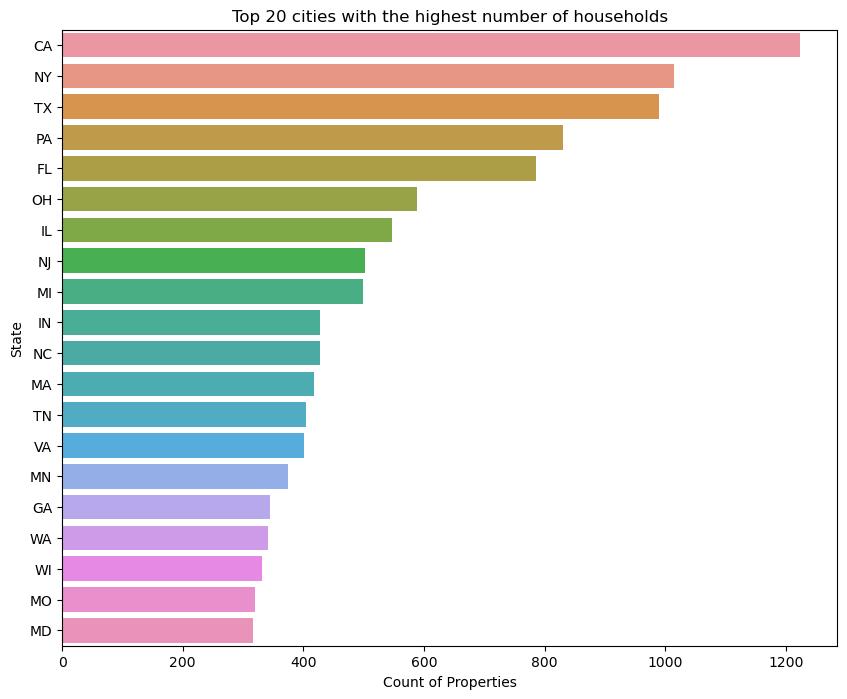

In [27]:
# Use the function to plot bar plots.

df_states20 = df_states.head(20)

plt.figure(figsize=(10, 8))
sns.barplot(data=df_states20, y='State', x='Count of Properties')
plt.title("Top 20 cities with the highest number of households")
plt.xlabel("Count of Properties")
plt.ylabel("State")
plt.show()



The State of California, New York and Texas have the highest number of property distributions.

Let's see the counties and states and their respective properties distribution.

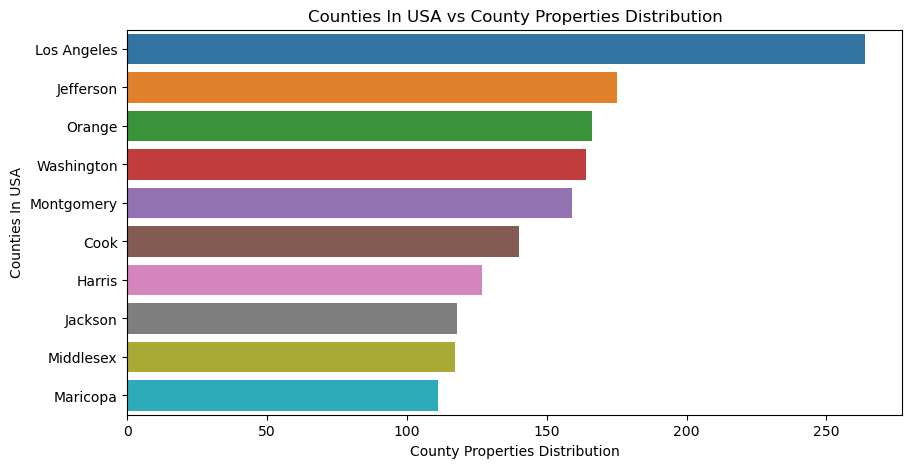

In [28]:
plot_barplot(dataframe=df[['RegionID', 'CountyName']].groupby('CountyName').count().reset_index().sort_values(
    by='RegionID', ascending=False).head(10), y='CountyName', x='RegionID', y_title='Counties In USA', x_title='County Properties Distribution')

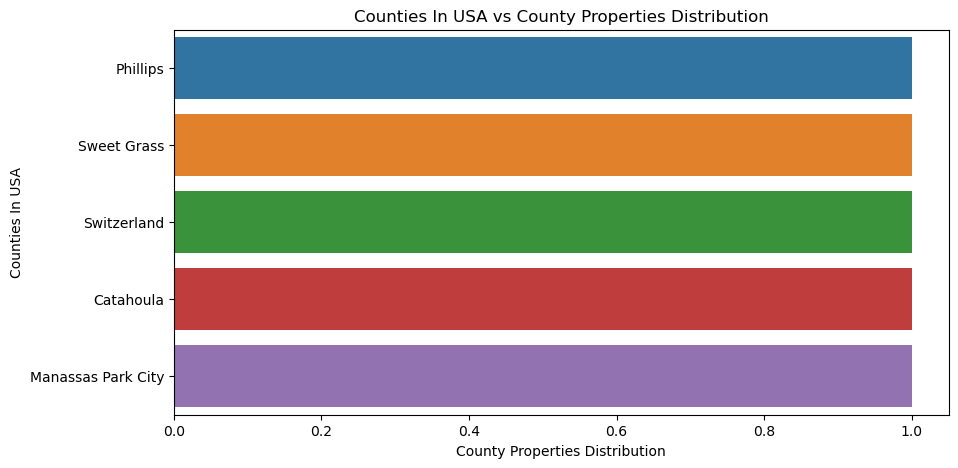

In [29]:
plot_barplot(dataframe=df[['RegionID', 'CountyName']].groupby('CountyName').count().reset_index().sort_values(
    by='RegionID', ascending=False).tail(), y='CountyName', x='RegionID', y_title='Counties In USA', x_title='County Properties Distribution')

In [30]:
#The lowest listing per county was 1 property.

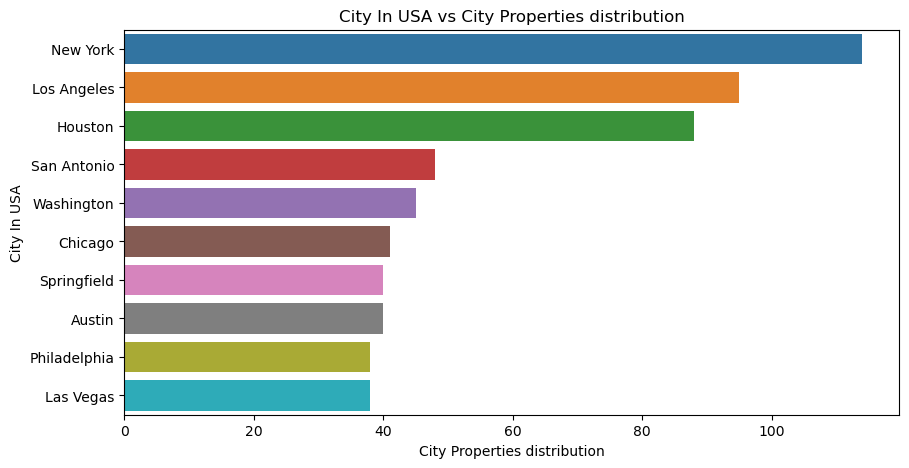

In [31]:
# Apply the barplot function to get property distribution accross cities.
plot_barplot(dataframe=df[['RegionID', 'City']].groupby('City').count().reset_index().sort_values(
    by='RegionID', ascending=False).head(10), y='City', x='RegionID', y_title='City In USA', x_title='City Properties distribution')

In [32]:
# Group data by metro and region name so as to get a view of average worth in a specific zipcode.
metro_value = pd.DataFrame(df_melted.groupby(['Metro','RegionName'])['value'].agg('mean').sort_values(ascending=False).head(10))
metro_value

value
Metro                          RegionName              
New York                       10021       1.285427e+07
                               10011       7.755844e+06
                               10014       6.836902e+06
                               10128       5.085436e+06
San Francisco                  94027       3.487129e+06
Glenwood Springs               81611       3.147124e+06
Los Angeles-Long Beach-Anaheim 90210       2.789977e+06
Miami-Fort Lauderdale          33480       2.634498e+06
San Francisco                  94123       2.630977e+06
Brunswick                      31561       2.403194e+06

**New york metropolitan has 4 zipcodes categorized to be having the most valuable properties listed.**

In [33]:
#why don't we check  out the lowest too?
metro_value = pd.DataFrame(df_melted.groupby(['Metro','RegionName'])['value'].agg('mean').sort_values(ascending=False).tail(10))
metro_value

value
Metro                       RegionName              
Tulsa                       74030       28101.132075
                            74110       27110.566038
Reading                     19602       26036.981132
Oklahoma City               73129       25691.320755
Louisville/Jefferson County 40210       25436.842105
Nashville                   37137       25389.056604
Miami                       74339       23512.075472
Madisonville                42410       22089.433962
Dayton                      45406       20846.875000
Memphis                     72331       19866.792453

**Memphis metropitan seems to have the lowest average value of property listed**

### <b><span style='color:#16C2D5'>|</span> Average house prices by state</b>
This is done using the groupby function on the house values.

<Axes: xlabel='State', ylabel='value'>

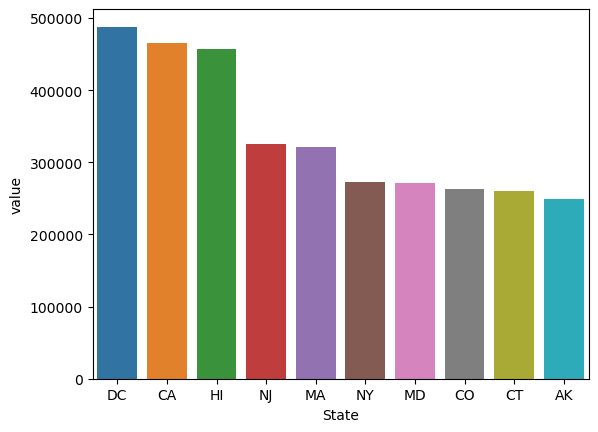

In [34]:
# Average of listed properties prices by state
state_group = df_melted.groupby('State')['value'].agg('mean').sort_values(ascending=False).head(10)

sns.barplot(data=state_group.reset_index(), x='State', y='value')

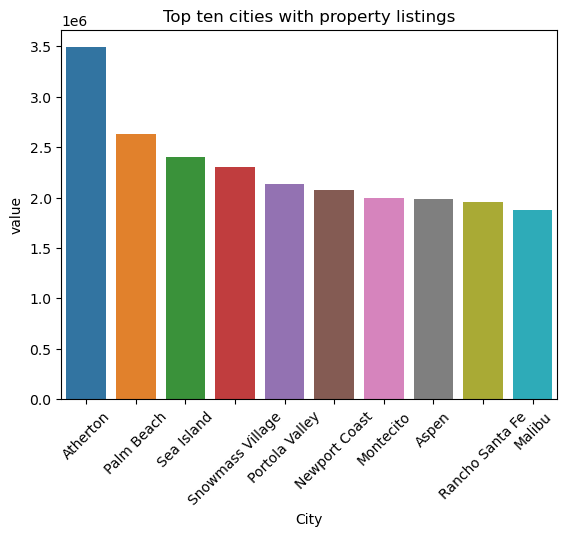

In [35]:
#Analyze distribution of properties per city.
group_cities = pd.DataFrame(df_melted.groupby('City')['value'].agg('mean').sort_values(ascending=False)).head(10)

sns.barplot(data=group_cities.reset_index(), x='City', y='value')
plt.title("Top ten cities with property listings")
plt.xticks(rotation=45)
plt.show()

### <b><span style='color:#16C2D5'>|</span> Market crash analysis</b>
The housing market crash of 2008 had a significant impact on U.S. housing prices, causing them to plummet. In the years leading up to the crash, housing prices had risen sharply, fueled by a speculative housing market and easy access to credit. However, when the subprime mortgage crisis hit and defaults began to soar, the bubble burst and housing prices fell dramatically.

We'll focus on the zipcodes that are high value and see the effect on the prices.

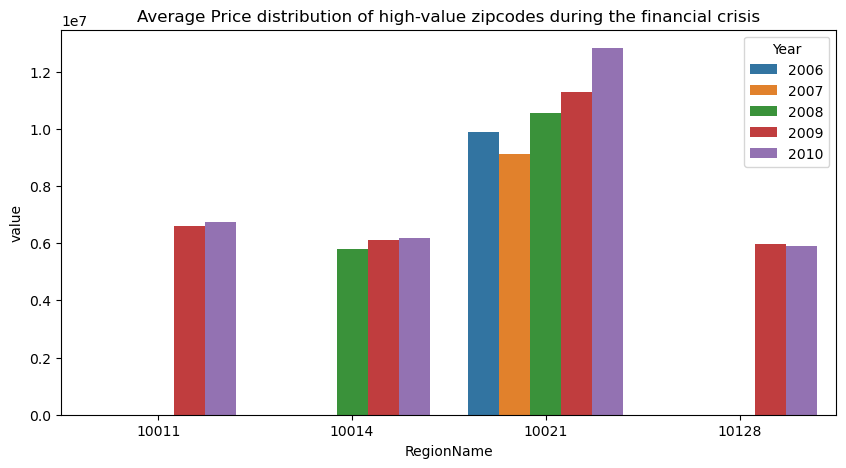

In [36]:
# Analysis of market crash crisis on regions.
high_value_regions = [10021, 10011, 10014, 10128, 94027, 81611, 90210, 33480, 94123, 31561,
                   94115, 94109, 81615, 90402, 92067, 90020, 94028, 94301, 7620, 92657,
                   94022, 94957, 93108, 11217, 94305, 2116, 90265, 94133, 11976, 90049]


years = [2006,2007,2008, 2009, 2010]

plt.figure(figsize=(10,5))
filtered_df = df_melted[(df_melted['Year'].isin(years)) & df_melted['RegionName'].isin(high_value_regions)]
group_crisis = pd.DataFrame(filtered_df.groupby(['RegionName','Year'])['value'].agg('mean').sort_values(ascending=False)).head(12)
sns.barplot(data=group_crisis.reset_index(), x='RegionName', y='value', hue='Year')
plt.title("Average Price distribution of high-value zipcodes during the financial crisis")
plt.show()


### <b><span style='color:#16C2D5'>|</span> Market crash analysis</b>
We aim to obtain distribution of house prices in low-end zip codes during the crisis.

***We group the zipcodes into two: Low_value & High_value, we'll consider the previous property average value in the different metroplitans as deciphered earlier***

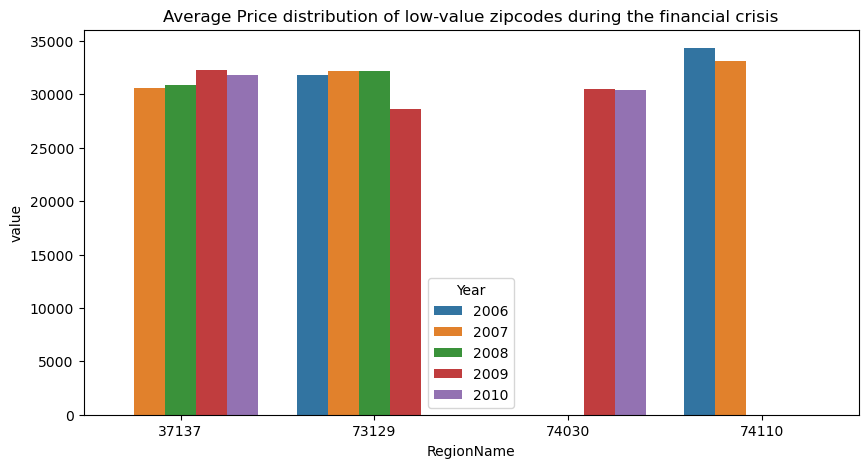

In [37]:
low_value_regions= [74030,74110,26036,73129,40210,37137,74339,42410,45406,72331]

plt.figure(figsize=(10,5))
filtered_df = df_melted[(df_melted['Year'].isin(years)) & df_melted['RegionName'].isin(low_value_regions)]
group_crisis = pd.DataFrame(filtered_df.groupby(['RegionName','Year'])['value'].agg('mean').sort_values(ascending=False)).head(12)
sns.barplot(data=group_crisis.reset_index(), x='RegionName', y='value', hue='Year')
plt.title("Average Price distribution of low-value zipcodes during the financial crisis")
plt.show()

### <b><span style='color:#16C2D5'>|</span> Metropolitan growth rates</b>
Grouping data based on the paercentage difference of past house values using the **pct_change** from pandas.

In [38]:
df_melted.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value,Year,Month
0,60657,84654,1,Chicago,IL,Chicago,Cook,1996-04-01,334200.0,1996,4
1,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0,1996,4
2,77494,91982,3,Katy,TX,Houston,Harris,1996-04-01,210400.0,1996,4
3,60614,84616,4,Chicago,IL,Chicago,Cook,1996-04-01,498100.0,1996,4
4,79936,93144,5,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0,1996,4


In [39]:
#Function that will be used to call the average value of properties in specific cities in a range of years
def average_value_for_city_year(df, city, years):
    """
    Calculates the average value of properties in a certain city for each year within a specified range.
    """
    # Filter the DataFrame based on the city
    filtered_df = df[df['City'] == city]

    # Initialize an empty dictionary to store results
    result_dict = {'Year': [], 'Average Value': []}

    # Loop through the years in the specified range and calculate the average value for each year
    for year in range(years[0], years[1] + 1):
        average_value = filtered_df[filtered_df['Year'] == year]['value'].mean()
        result_dict['Year'].append(year)
        result_dict['Average Value'].append(average_value)

    # Create a DataFrame from the result dictionary
    result_df = pd.DataFrame(result_dict)

    return result_df


**let's work with one high value city and one low value city as per our previous classification and see the metropolitan growth trend
we chose New york as the high value**

In [40]:
#let's explore the growth pre-market crisis
newyork_average_value = average_value_for_city_year(df_melted, 'New York', years=[1996, 2006])
print(newyork_average_value)

    Year  Average Value
0   1996  216966.773504
1   1997  224839.102564
2   1998  236545.432692
3   1999  250879.727564
4   2000  274860.897436
5   2001  306658.333333
6   2002  338789.983974
7   2003  393097.607656
8   2004  577861.036036
9   2005  692566.741071
10  2006  771850.372024


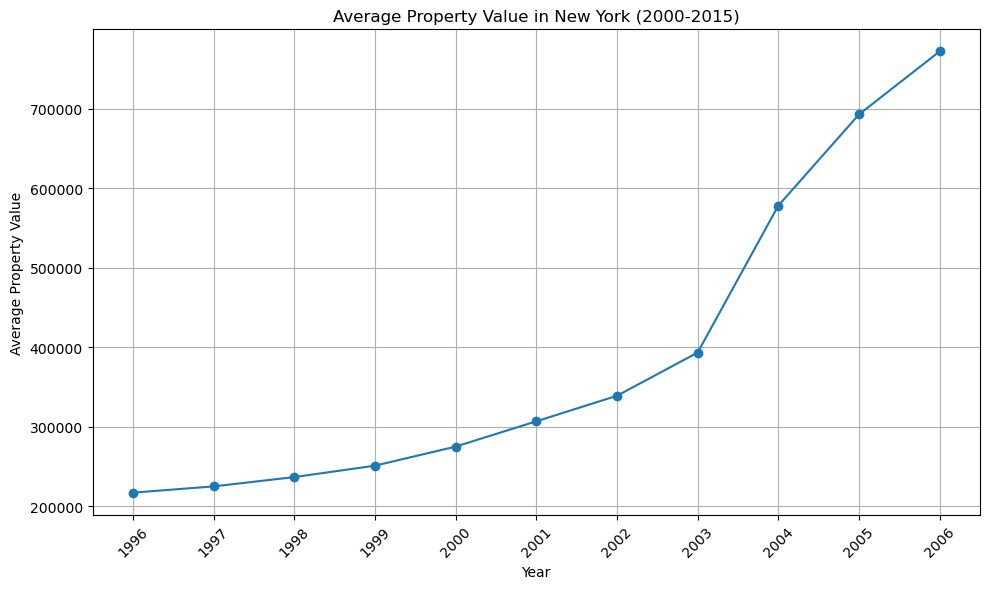

In [41]:
#plot the growth trend
plt.figure(figsize=(10, 6))
plt.plot(newyork_average_value['Year'], newyork_average_value['Average Value'], marker='o', linestyle='-')
plt.title('Average Property Value in New York (2000-2015)')
plt.xlabel('Year')
plt.ylabel('Average Property Value')
plt.grid(True)
plt.xticks(newyork_average_value['Year'], rotation=45)
plt.tight_layout()
plt.show()

In [42]:
#let's explore the growth post-market crisis
newyork_average_value2 = average_value_for_city_year(df_melted, 'New York', years=[2010, 2018])
print(newyork_average_value2)

   Year  Average Value
0  2010   7.693542e+05
1  2011   7.754202e+05
2  2012   7.686808e+05
3  2013   8.118726e+05
4  2014   9.218940e+05
5  2015   1.035182e+06
6  2016   1.097767e+06
7  2017   1.160024e+06
8  2018   1.186235e+06


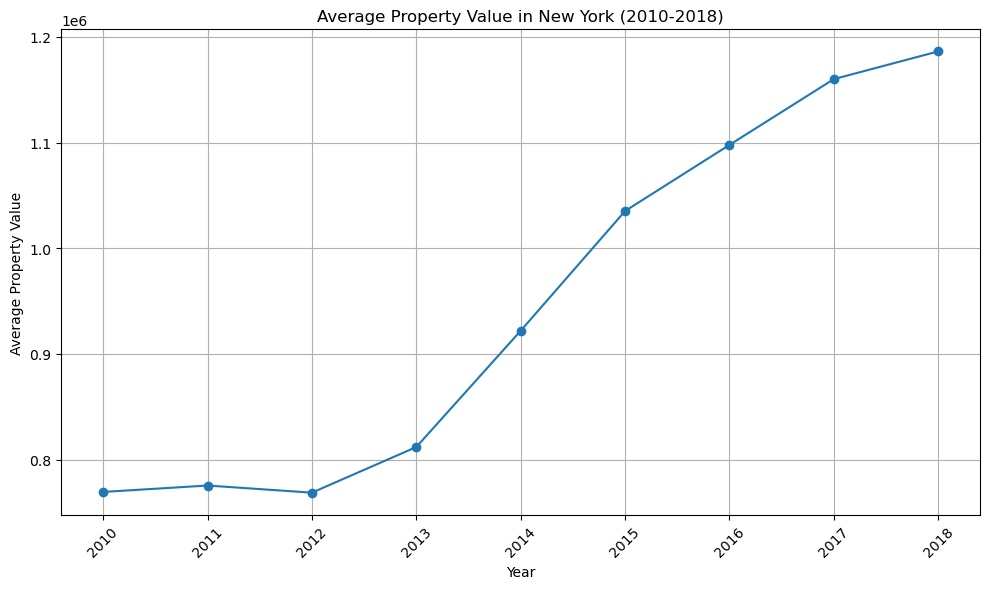

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(newyork_average_value2['Year'], newyork_average_value2['Average Value'], marker='o', linestyle='-')
plt.title('Average Property Value in New York (2010-2018)')
plt.xlabel('Year')
plt.ylabel('Average Property Value')
plt.grid(True)
plt.xticks(newyork_average_value2['Year'], rotation=45)  # Use newyork_average_value2['Year'] here
plt.tight_layout()
plt.show()

**Let's see how the growth pattern in the metropol that had the lowest value**

In [44]:
#let's explore the growth post-market crisis
memphis_value = average_value_for_city_year(df_melted, 'Memphis', years=[1996, 2018])
print(memphis_value)


    Year  Average Value
0   1996   91349.305556
1   1997   94893.229167
2   1998   99314.583333
3   1999  104577.604167
4   2000  110064.583333
5   2001  112541.666667
6   2002  114221.875000
7   2003  116062.500000
8   2004  119433.333333
9   2005  123833.854167
10  2006  127590.625000
11  2007  129079.687500
12  2008  116309.375000
13  2009  101003.645833
14  2010  100033.854167
15  2011   97997.395833
16  2012   96018.229167
17  2013   98643.137255
18  2014  103598.529412
19  2015  106668.627451
20  2016  114730.392157
21  2017  127071.078431
22  2018  134708.823529


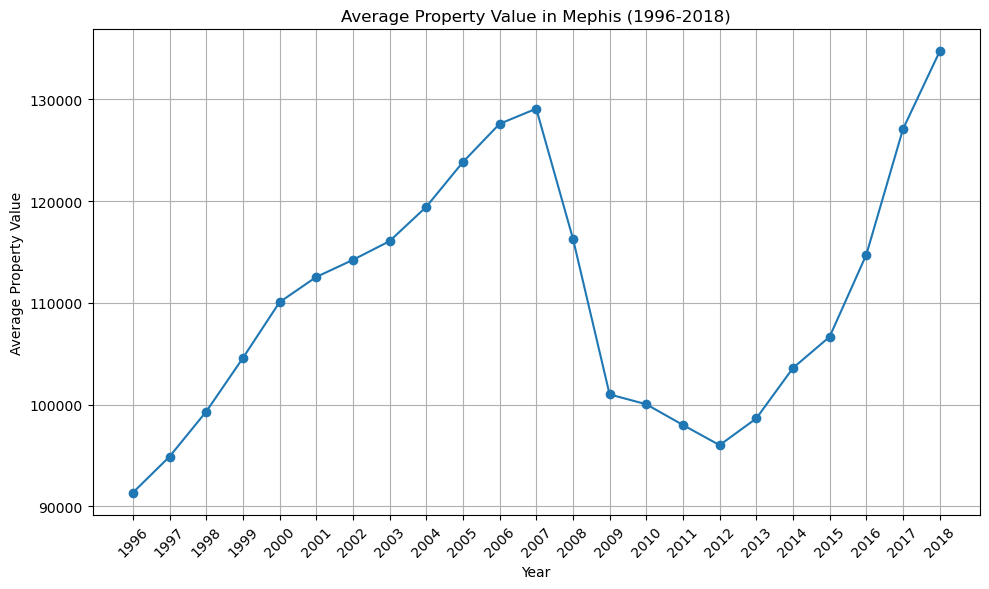

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(memphis_value['Year'], memphis_value['Average Value'], marker='o', linestyle='-')
plt.title('Average Property Value in Mephis (1996-2018)')
plt.xlabel('Year')
plt.ylabel('Average Property Value')
plt.grid(True)
plt.xticks(memphis_value['Year'], rotation=45)  # Use newyork_average_value2['Year'] here
plt.tight_layout()
plt.show()

**We clearly see the effects of the market crisis in Memphis metropol and the growth trend.**


# Now let's visualize the Metroplitan growth rates, we'll look at the top and the lowest growth rate across the data set

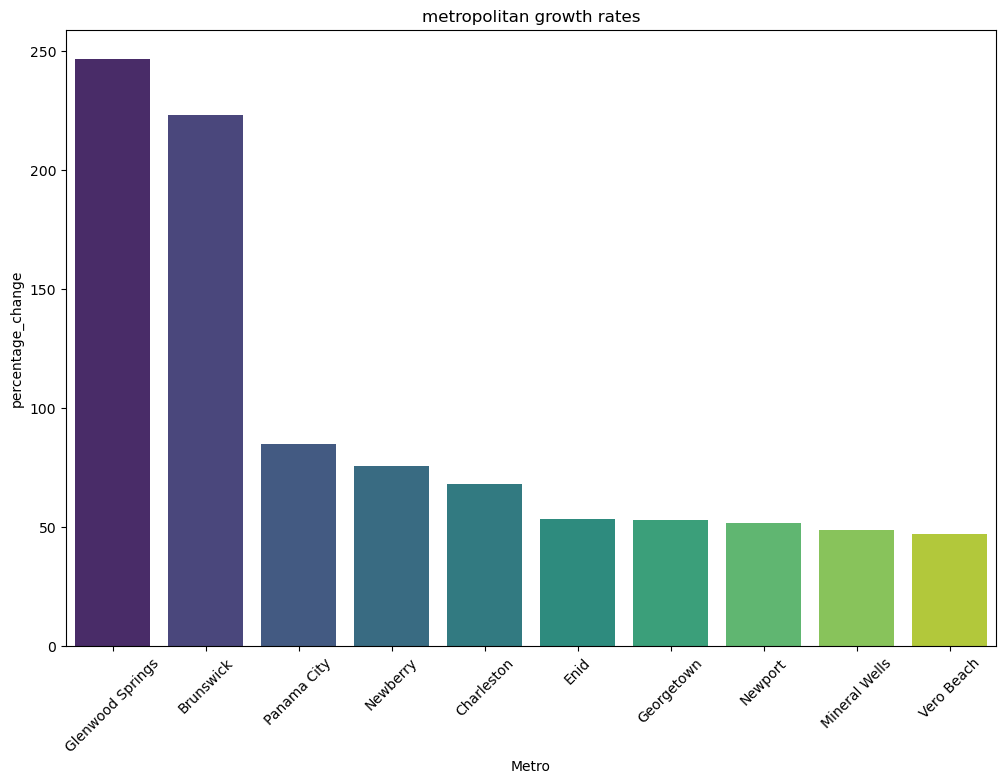

In [46]:
# Growth rates of metroplolitan areas.
df_melted['percentage_change'] = df_melted.groupby('Metro')['value'].pct_change() * 100
plt.figure(figsize=(12, 8))
average_percentage_change = pd.DataFrame(df_melted.groupby('Metro')['percentage_change'].mean().sort_values(ascending=False)).head(10)
sns.barplot(data=average_percentage_change.reset_index(), x='Metro', y='percentage_change', palette='viridis')
plt.title("metropolitan growth rates")
plt.xticks(rotation=45)
plt.show()


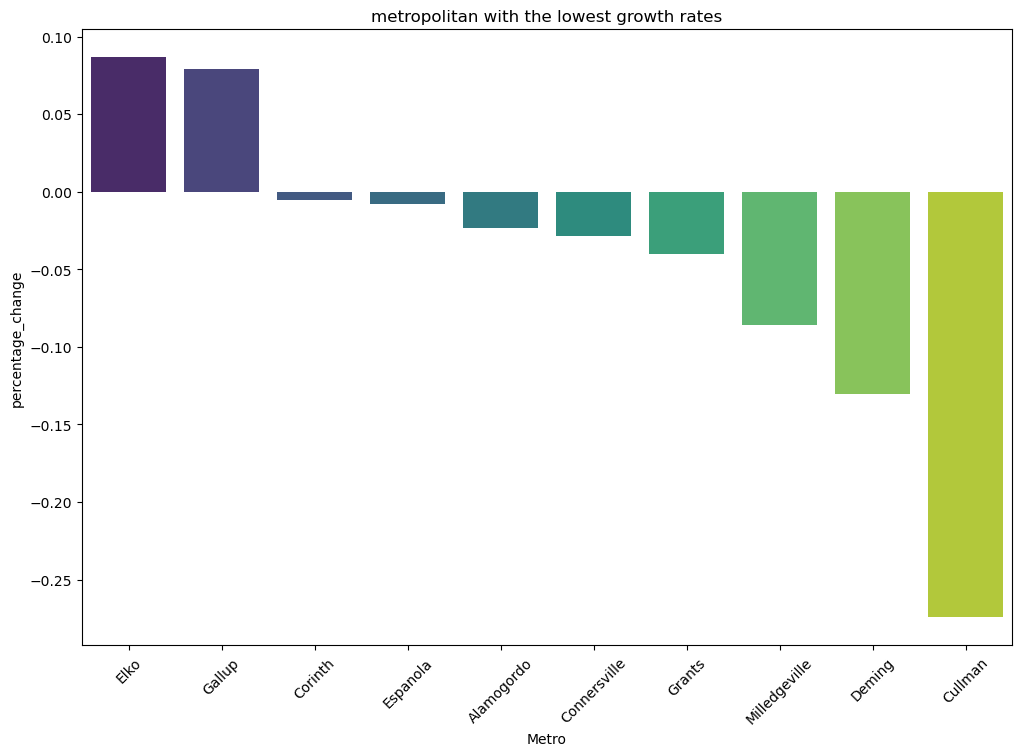

In [47]:
df_melted['percentage_change'] = df_melted.groupby('Metro')['value'].pct_change() * 100
plt.figure(figsize=(12, 8))
average_percentage_change = pd.DataFrame(df_melted.groupby('Metro')['percentage_change'].mean().sort_values(ascending=False)).tail(10)
sns.barplot(data=average_percentage_change.reset_index(), x='Metro', y='percentage_change', palette='viridis')
plt.title("metropolitan with the lowest growth rates")
plt.xticks(rotation=45)
plt.show()

In [48]:
df_melted.head(2)

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value,Year,Month,percentage_change
0,60657,84654,1,Chicago,IL,Chicago,Cook,1996-04-01,334200.0,1996,4,NaN
1,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0,1996,4,NaN


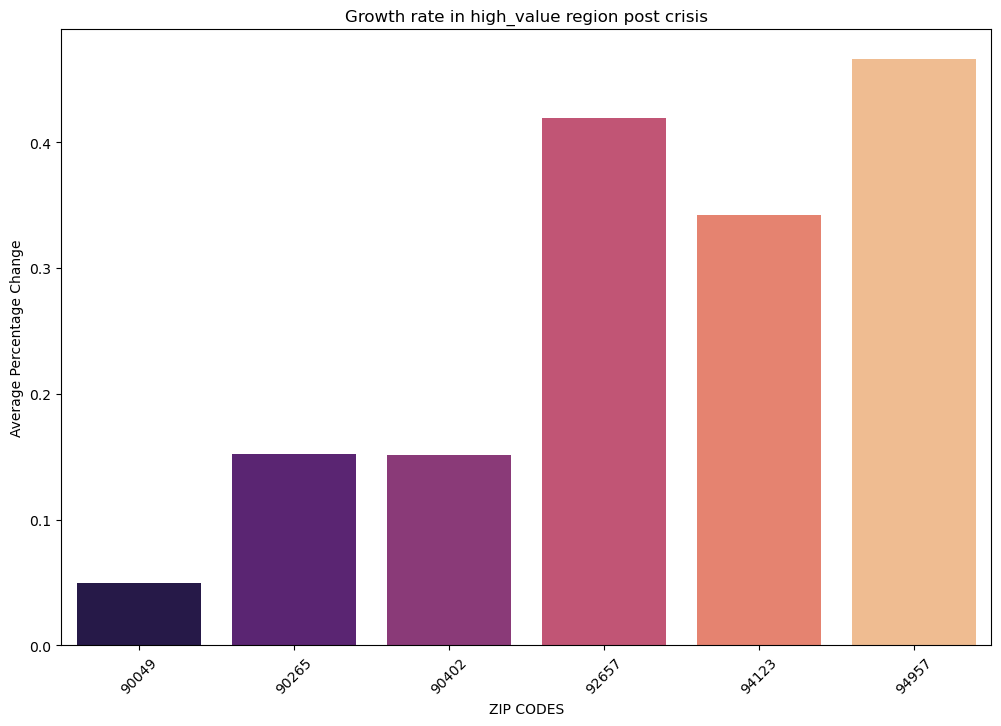

In [49]:
high_value_regions = [10021, 10011, 10014, 10128, 94027, 81611, 90210, 33480, 94123, 31561,
                   94115, 94109, 81615, 90402, 92067, 90020, 94028, 94301, 7620, 92657,
                   94022, 94957, 93108, 11217, 94305, 2116, 90265, 94133, 11976, 90049]

plt.figure(figsize=(12, 8))

# The start date for calculating percentage change
start_date = '2010-01-01'

# Filter the DataFrame to include data from the specified start date onwards
df_filtered = df_melted[df_melted['time'] >= start_date]
df_filtered = df_filtered[df_filtered['RegionID'].isin(high_value_regions)]
# Calculate percentage change and average percentage change
df_filtered['percentage_change'] = df_filtered.groupby('RegionID')['value'].pct_change() * 100
average_percentage_change = pd.DataFrame(df_filtered.groupby('RegionID')['percentage_change'].mean().sort_values(ascending=False)).tail(10)

# Bar plot
sns.barplot(data=average_percentage_change.reset_index(), x='RegionID', y='percentage_change', palette='magma')

# title and labels
plt.title("Growth rate in high_value region post crisis")
plt.xlabel('ZIP CODES')
plt.ylabel('Average Percentage Change')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()



### <b><span style='color:#16C2D5'>|</span> Post crisis growth rate analysis.</b>
**What was the growth rate post crisis?**



**What were the best and worst performing metro's?**

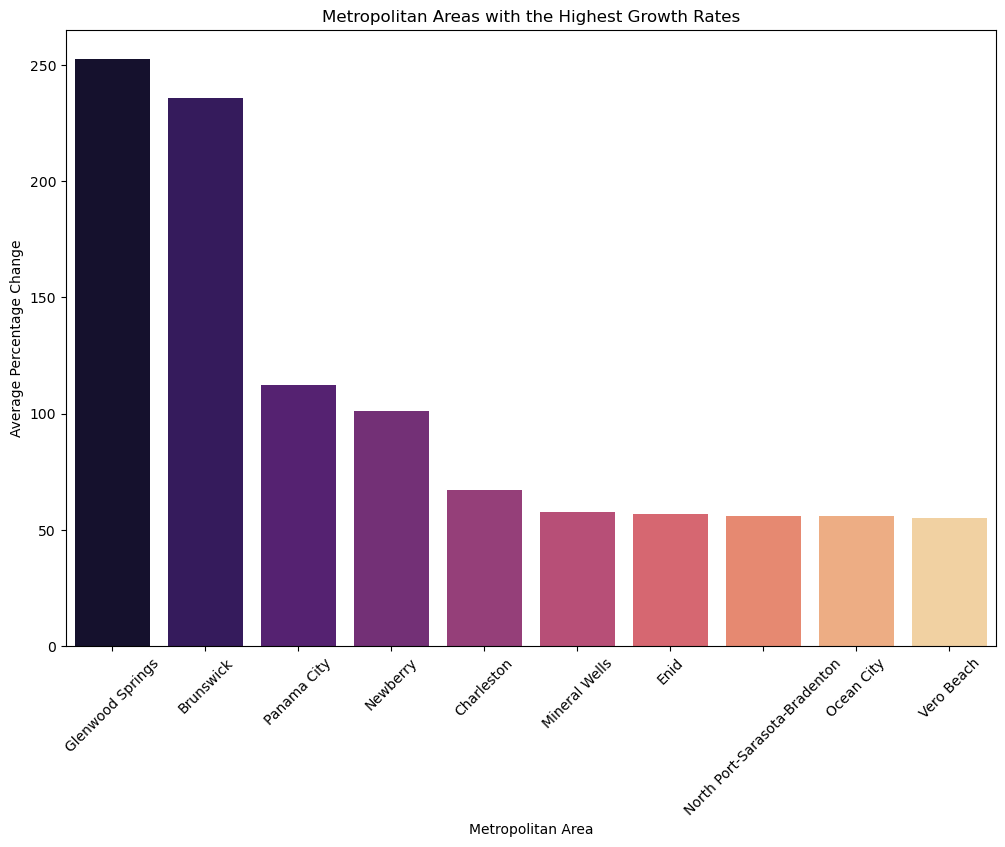

In [50]:
plt.figure(figsize=(12, 8))

# The start date for calculating percentage change
start_date = '2010-01-01'

# Filter the DataFrame to include data from the specified start date onwards
df_filtered = df_melted[df_melted['time'] >= start_date]

# Calculate percentage change and average percentage change
df_filtered['percentage_change'] = df_filtered.groupby('Metro')['value'].pct_change() * 100
average_percentage_change = pd.DataFrame(df_filtered.groupby('Metro')['percentage_change'].mean().sort_values(ascending=False)).head(10)

# Bar plot
sns.barplot(data=average_percentage_change.reset_index(), x='Metro', y='percentage_change', palette='magma')

# title and labels
plt.title("Metropolitan Areas with the Highest Growth Rates")
plt.xlabel('Metropolitan Area')
plt.ylabel('Average Percentage Change')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()

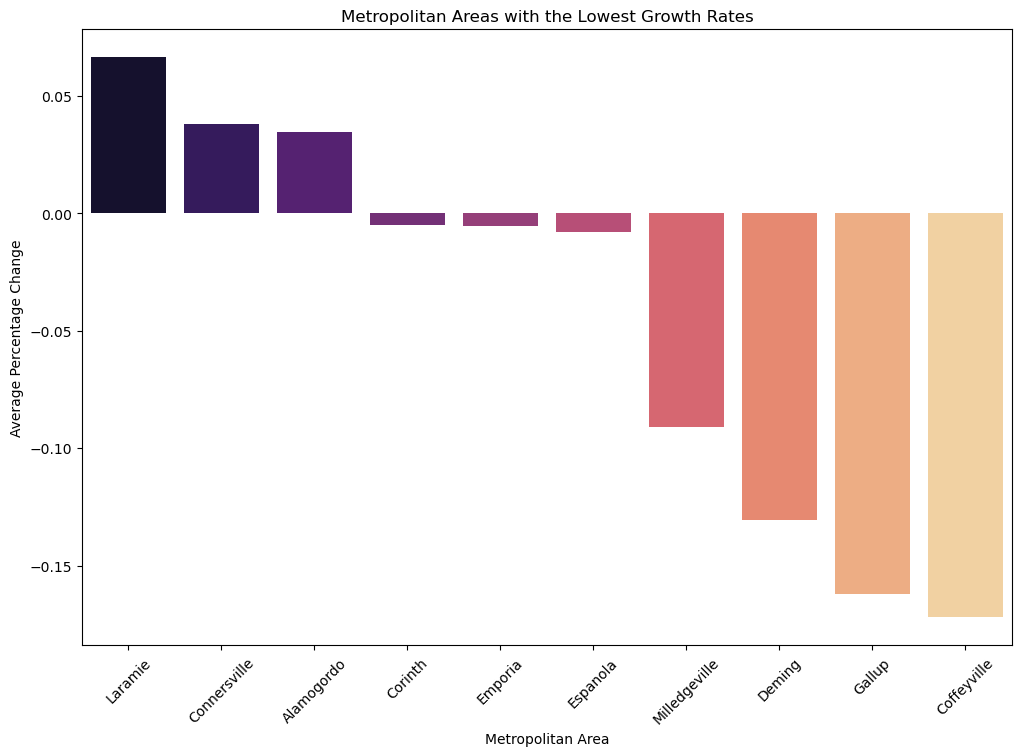

In [51]:
plt.figure(figsize=(12, 8))

# The start date for calculating percentage change
start_date = '2010-01-01'

# Filter the DataFrame to include data from the specified start date onwards
df_filtered = df_melted[df_melted['time'] >= start_date]

# Calculate percentage change and average percentage change
df_filtered['percentage_change'] = df_filtered.groupby('Metro')['value'].pct_change() * 100
average_percentage_change = pd.DataFrame(df_filtered.groupby('Metro')['percentage_change'].mean().sort_values(ascending=False)).tail(10)

# Bar plot
sns.barplot(data=average_percentage_change.reset_index(), x='Metro', y='percentage_change', palette='magma')

# title and labels
plt.title("Metropolitan Areas with the Lowest Growth Rates")
plt.xlabel('Metropolitan Area')
plt.ylabel('Average Percentage Change')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()

### <b> <span style='color:#16C2D5'>|</span> EDA Conclusion</b>

* California Metro has the highest number of properties listed.
* ZipCodes **10021, 10011, 10014** and **10128** were among the top priced regions, which apparently were among the Zipcodes less affected by the 2008 financial crisis.
* Memphis had the lowest valuable property listed.
* Property pre-categorized among the high value ZipCodes were not greatly affected by the market crisis unlike the drop in value observed post crisis in the low value ZipCodes
* Post-crisis growth rate is still positive for the high value ZipCodes despite seeing growth rates even went into negatives for some Metro's


## 3. Modelling 


By understanding the patterns, trends, and seasonal variations within the data, time series models enable us to make informed predictions about future values.
 Since most time series data always has the component of trend and sesonality, ARIMA models have the idea of differencing to ensure stationarity.


We seek out to build a  model to predict the house prices for the **ZipCodes** which are high priced and have good prospects for  a good **Return on Investment**. We chose the ZIPCODE as a baseline as it is the lowest geographic presentation level in our data

Work plan:
* Data transformation
* Data Resampling
* Baseline model
* Arima Models
* Facebook Prophet(ETL pipeline)

In [52]:
# Copy the melted df for easy workability.
df = df_melted.copy()


Setting the time as the index column simplifies resampling and data slicing. With the large number of rows resulting from the melting function, training models requires only a fraction of the data to adequately represent the entire population. This approach is essential as models, particularly ARMA models, can be computationally burdensome on very large datasets, lacking efficiency in handling big data.

In [53]:
df.set_index('time', inplace=True)
df.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value,Year,Month,percentage_change
time,,,,,,,,,,,
1996-04-01,60657,84654,1,Chicago,IL,Chicago,Cook,334200.0,1996,4,NaN
1996-04-01,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,235700.0,1996,4,NaN
1996-04-01,77494,91982,3,Katy,TX,Houston,Harris,210400.0,1996,4,NaN
1996-04-01,60614,84616,4,Chicago,IL,Chicago,Cook,498100.0,1996,4,49.04249
1996-04-01,79936,93144,5,El Paso,TX,El Paso,El Paso,77300.0,1996,4,NaN


### <b> <span style='color:#16C2D5'>|</span> Data Resampling</b>
Data resampling is a process used in time series analysis to change the frequency of the data observations. It involves aggregating or transforming the data from one time frequency to another, such as from daily to monthly or from hourly to weekly. Resampling can be performed in two main ways: upsampling and downsampling.

The data at our disposal seems to be on a month start basis and that is the best resampling technique for this problem.




<Axes: xlabel='time'>

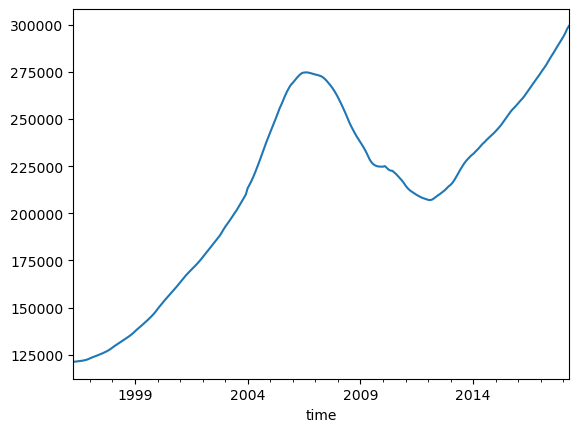

In [54]:
# Resample data on a monthly basis.
#resampling the 'value' column from df to have monthly frequency.
df2= df['value'].resample('MS').mean()
df2.plot()

The plot of the monthly resampled data illustrates a consistent upward trend from 1999 to 2007, largely driven by the proliferation of subprime housing mortgages targeted at low-income earners. However, beginning in 2008, there is a notable and sustained decline in property values, attributed to the housing market crash of that year. This period coincided with a housing crisis in the United States, primarily stemming from the prevalence of subprime mortgages, extensive debt burdens, and lax financial sector regulations. Consequently, home values plummeted, leading to widespread challenges for homeowners and investors in meeting their mortgage obligations.


We examined the autocorrelation plots of our data to assess for the presence of seasonality. A strong seasonal pattern would be indicated by peaks at regular intervals in the autocorrelation function (ACF) plot. Similarly, in the partial autocorrelation function (PACF) plot, significant spikes at lag intervals would suggest the presence of seasonality. 

In [55]:
# Function for the autocorrellation plots
def corr_plots(data):
    acf_diff = plot_acf(data)
    pacf_plot = plot_pacf(data)
    adfttest = adfuller(data)


    return acf_diff, pacf_plot

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

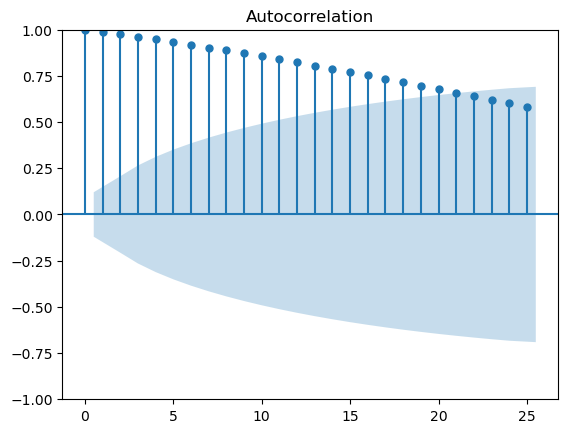

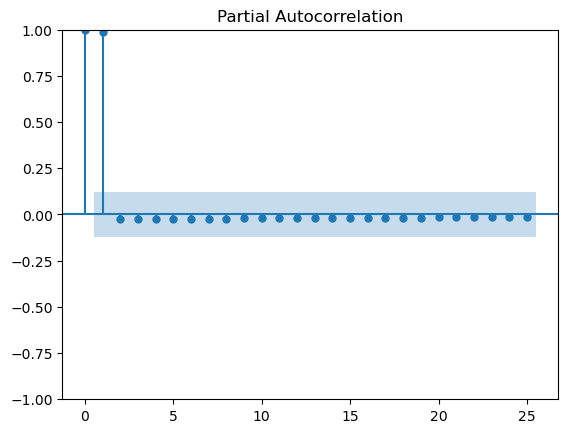

In [56]:
corr_plots(df2)

From the auto-correlation plots, it is very evident that the house value drop between 2008 and 2012 introduced very high seasonality.

# **BASELINE MODEL**


Working with the whole data set is impractical and expensive too soo we'll take the top 30 high value ZIP CODES.

In [57]:
df_melted.head(2)

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value,Year,Month,percentage_change
0,60657,84654,1,Chicago,IL,Chicago,Cook,1996-04-01,334200.0,1996,4,NaN
1,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0,1996,4,NaN


In [58]:
# Baseline model for forecast of specific zip codes.
high_value_zipcodes = [10021, 10011, 10014, 10128, 94027, 81611, 90210, 33480, 94123, 31561,
                   94115, 94109, 81615, 90402, 92067, 90020, 94028, 94301, 7620, 92657,
                   94022, 94957, 93108, 11217, 94305, 2116, 90265, 94133, 11976, 90049]

# split the time series data into 5 train-test pairs
tsc = TimeSeriesSplit(n_splits=5)

all_train_dates, all_test_dates = [], []
all_train_values, all_test_values = [], []
all_forecasts = []

results_list1 = []

for county in high_value_zipcodes:
    county_data = df_melted[df_melted['RegionName'] == county]

    # Split the data
    dates = county_data.index
    values = county_data['value'].values

    # accumulate values for each fold
    zip_train_dates, zip_test_dates = [], []
    zip_train_values, zip_test_values = [], []

    for train_index, test_index in tsc.split(dates):
        train_dates, test_dates = dates[train_index], dates[test_index]
        train_values, test_values = values[train_index], values[test_index]

        zip_train_dates.extend(train_dates)
        zip_test_dates.extend(test_dates)
        zip_train_values.extend(train_values)
        zip_test_values.extend(test_values)


        baseline_model = ARIMA(train_values, order=(1, 0, 1)).fit()
        forecast = pd.Series(baseline_model.predict(start=len(train_values), end=len(train_values) + 11, typ='levels'))

        print(baseline_model.summary())

        all_forecasts.extend(forecast)


        predicted_value = forecast.iloc[-1]
        real_value = test_values[-1]
        percentage_change = ((predicted_value - real_value) / real_value) * 100
        # Append the forecasted values to the list
        results_list1.append({'County': county, 'Forecast': predicted_value, 'Real': real_value, 'Percentage Change': percentage_change})


results_df = pd.DataFrame(results_list1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -441.951
Date:                Sun, 24 Mar 2024   AIC                            891.901
Time:                        06:48:40   BIC                            897.764
Sample:                             0   HQIC                           893.844
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.984e+06   1.05e-08   9.47e+14      0.000    9.98e+06    9.98e+06
ar.L1          0.9828      0.029     33.769      0.000       0.926       1.040
ma.L1          0.9563      0.371      2.577      0.0

In [59]:
print(results_df.head())
print(results_df.shape)

   County      Forecast        Real  Percentage Change
0   10021  9.830246e+06  10883800.0          -9.680016
1   10021  1.077231e+07  13043800.0         -17.414338
2   10021  1.275458e+07  11630200.0           9.667800
3   10021  1.158979e+07  18341500.0         -36.811086
4   10021  1.814075e+07  17894900.0           1.373850
(150, 4)


In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
forecast = results_df['Forecast']
actual = results_df['Real']


mape = np.mean(np.abs((actual - forecast) / actual)) * 100
smape = np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))) * 100


In [61]:

print("Mean absolute percentage error :", mape)
print("Symmetric Mean absolute percentage error :", smape)

Mean absolute percentage error : 22.44968804778763
Symmetric Mean absolute percentage error : 25.33295835471402


## Auto arima model

After doing forecasting on the selected zipcodes using a baseline model, we go ahead and try to use the auto arima to get the best pdq combinations to minimze the AIC score.

The idea of looping and using the **TrainTestSplit** comes in handy as various combinations are tried for every fold to get the lowest AIC scores.

In [62]:
pip install pmdarima

In [63]:
# Use the auto arima model to get the best pdq values.
from pmdarima import auto_arima
for county in high_value_zipcodes:
    county_data = df_melted[df_melted['RegionName'] == county]

    # Split the data
    dates = county_data.index
    values = county_data['value'].values

    # accumulate results for each fold
    zip_train_dates, zip_test_dates = [], []
    zip_train_values, zip_test_values = [], []

    for train_index, test_index in tsc.split(dates):
        train_dates, test_dates = dates[train_index], dates[test_index]
        train_values, test_values = values[train_index], values[test_index]

        zip_train_dates.extend(train_dates)
        zip_test_dates.extend(test_dates)
        zip_train_values.extend(train_values)
        zip_test_values.extend(test_values)


        auto_model = auto_arima(train_values, trace=True, suppress_warnings=True)
        auto_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=798.472, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=991.727, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=983.334, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1124.743, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=858.266, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=783.861, Time=0.23 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=833.611, Time=0.14 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=770.890, Time=0.29 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=823.210, Time=0.16 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=779.520, Time=0.52 sec
 

## ARIMA(0,2,0)



From the previous iteration we'll choose the best model parameters and apply them on the next model

In [64]:

def model_func(order):
    """
    Function to take in various pdq values and do forecasting on the selected values.
    """

    results_list2 = []
    for county in high_value_zipcodes:
        county_data = df_melted[df_melted['RegionName'] == county]

        # Split the data
        dates = county_data.index
        values = county_data['value'].values

        # accumulate values for each fold
        zip_train_dates, zip_test_dates = [], []
        zip_train_values, zip_test_values = [], []

        for train_index, test_index in tsc.split(dates):
            train_dates, test_dates = dates[train_index], dates[test_index]
            train_values, test_values = values[train_index], values[test_index]

            zip_train_dates.extend(train_dates)
            zip_test_dates.extend(test_dates)
            zip_train_values.extend(train_values)
            zip_test_values.extend(test_values)


            model = ARIMA(train_values, order=order).fit()
            forecast = pd.Series(model.predict(start=len(train_values), end=len(train_values) + 11, typ='levels'))

            print(model.summary())

            all_forecasts.extend(forecast)


            forecasted_value = forecast.iloc[-1]
            real_value = test_values[-1]
            percentage_change = ((forecasted_value - real_value) / real_value) * 100

            results_df = pd.DataFrame(results_list2.append({'County': county, 'Forecast': forecasted_value, 'Real': real_value, 'Percentage Change': percentage_change}))

    return results_df


In [65]:
#Apply function with the pdq values of (0,2,0)
model_func(order=(0,2,0))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -387.275
Date:                Sun, 24 Mar 2024   AIC                            776.550
Time:                        06:54:28   BIC                            777.951
Sample:                             0   HQIC                           776.998
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       8.94e+09   1.86e+09      4.802      0.000    5.29e+09    1.26e+10
Ljung-Box (L1) (Q):                  23.71   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.00   Pr

""


This model generates an AIC score of 776 which is pretty much lower than the baseline's model score of 891.

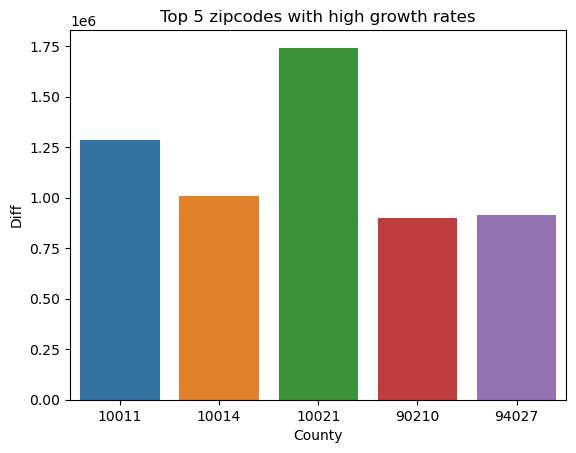

In [66]:
# Analyze the forecasted house values to get their respective growth rates.
avg_results2 = results_df.groupby('County')[['Forecast', 'Real']].mean().reset_index()
avg_results2['Diff'] =avg_results2['Real'] - avg_results2['Forecast']
top_5 = avg_results2.sort_values(by='Diff', ascending=False).head(5)
sns.barplot(data=top_5, x='County', y='Diff')
plt.title("Top 5 zipcodes with high growth rates")
plt.show()

## ARIMA(1,2,1)

We set out to try another combination of pdq values to analyze the **AIC scores** as compaired to the other **ARIMA** model.

In [67]:
#Apply function using the order (1,2,1).
model_func(order=(1,2,1))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -385.705
Date:                Sun, 24 Mar 2024   AIC                            777.410
Time:                        06:54:34   BIC                            781.613
Sample:                             0   HQIC                           778.754
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9276      0.025     36.979      0.000       0.878       0.977
ma.L1         -1.0000      0.267     -3.748      0.000      -1.523      -0.477
sigma2      8.404e+09   3.17e-11   2.65e+20      0.0

""


This model generates a higher AIC than the previous model. We aim to reduce the AIC scores. This model is not the perfect model to get the zipcodes which have a better prospects of growth.

**PROPHET MODEL**

Here we are creating a data pipeline which will enable data loading, model training, model results plotting 
and finaly evaluation of the same

08:47:36 - cmdstanpy - INFO - Chain [1] start processing
08:47:37 - cmdstanpy - INFO - Chain [1] done processing


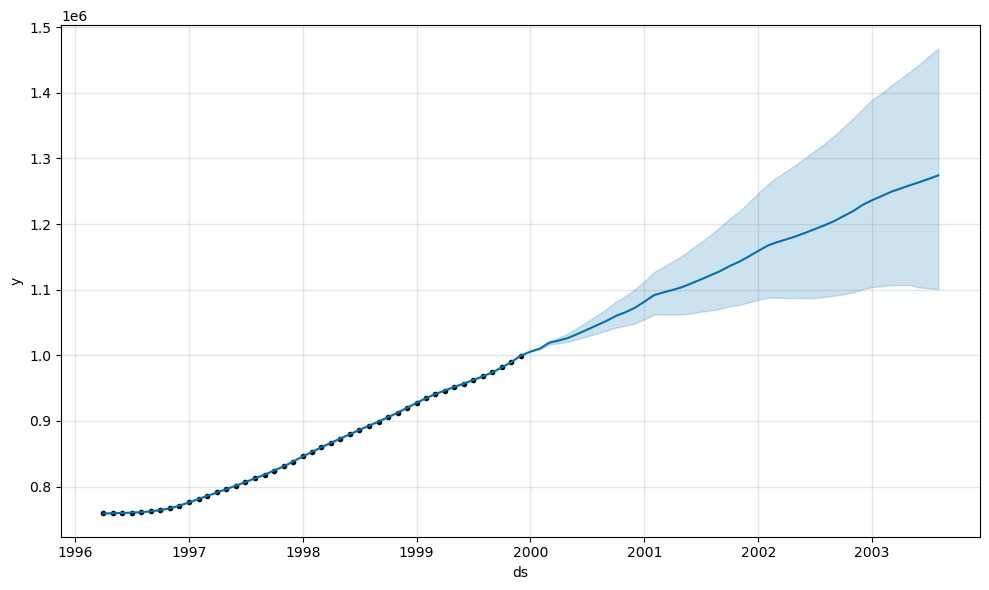

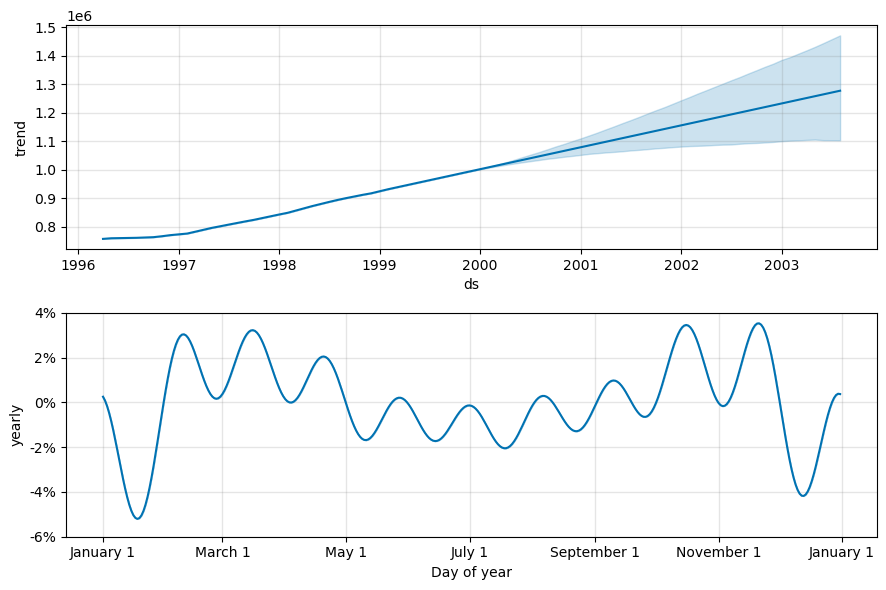

08:47:39 - cmdstanpy - INFO - Chain [1] start processing
08:47:39 - cmdstanpy - INFO - Chain [1] done processing


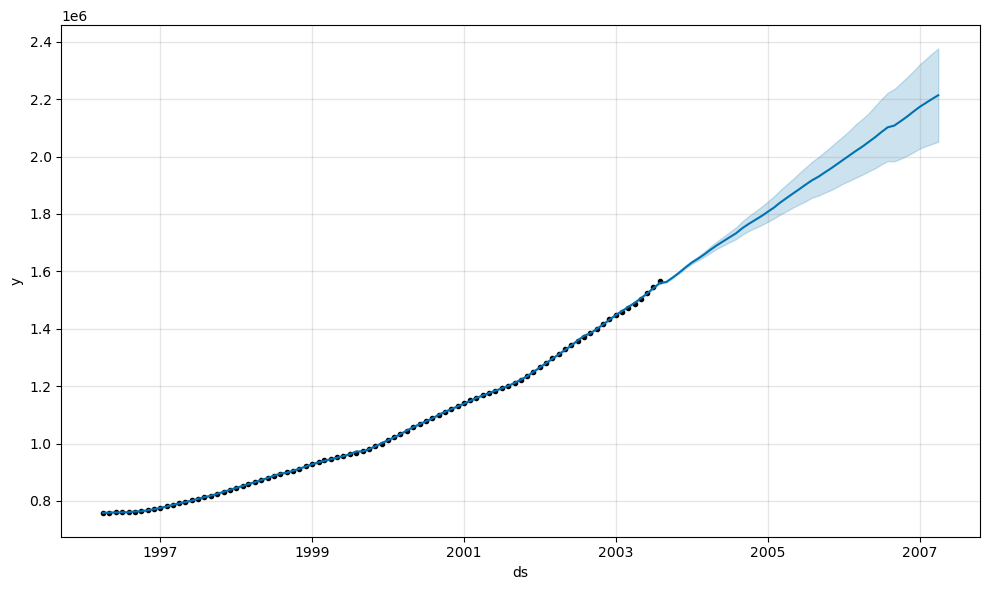

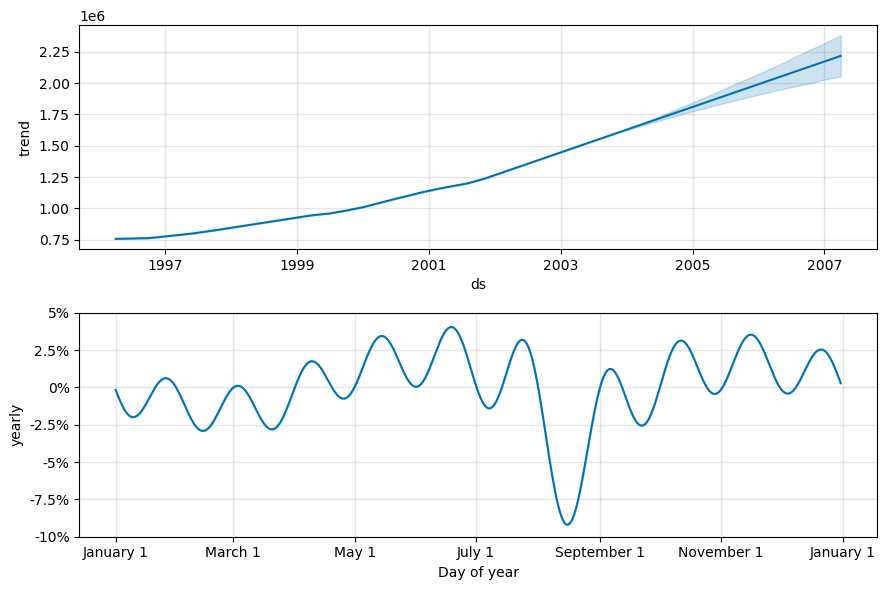

08:47:41 - cmdstanpy - INFO - Chain [1] start processing
08:47:41 - cmdstanpy - INFO - Chain [1] done processing


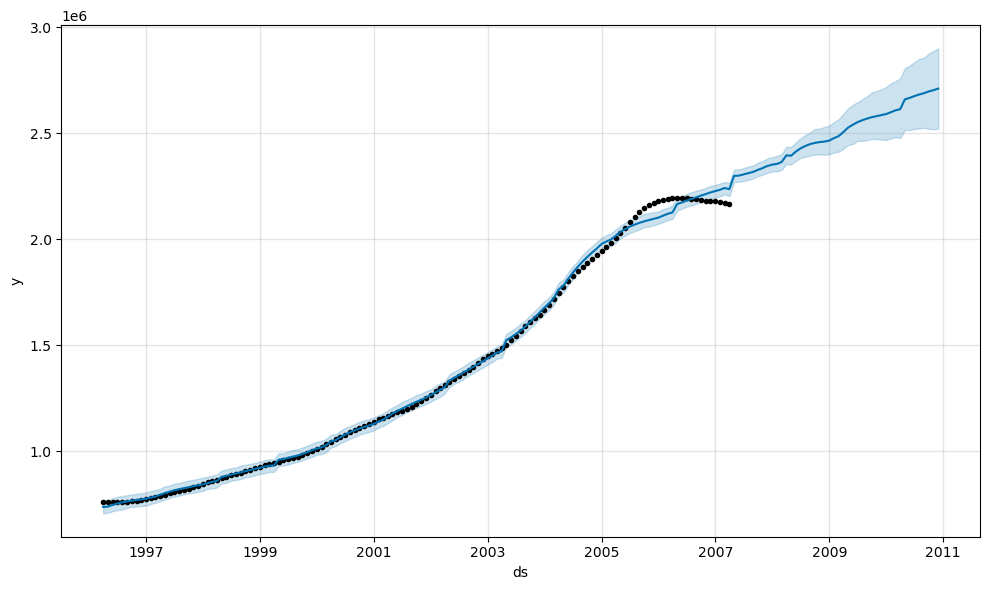

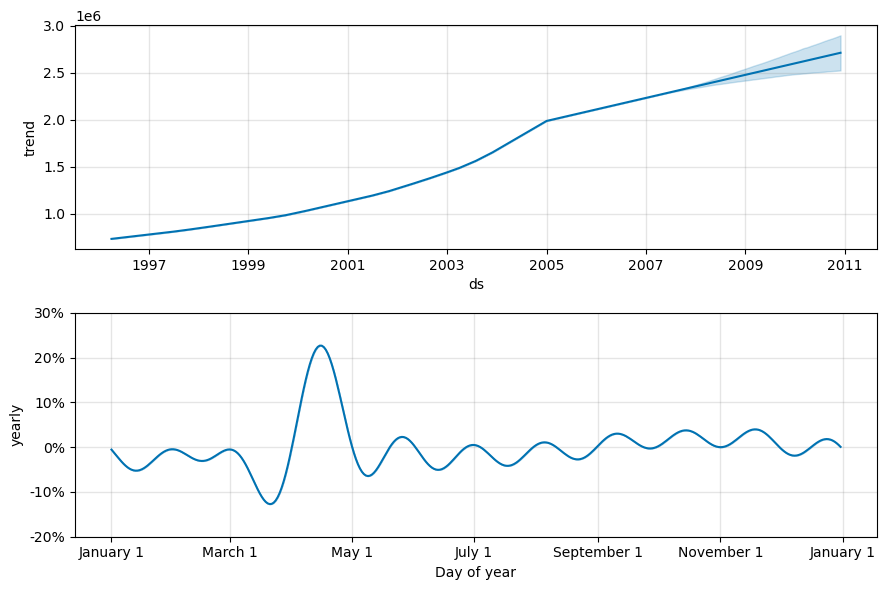

08:47:43 - cmdstanpy - INFO - Chain [1] start processing
08:47:43 - cmdstanpy - INFO - Chain [1] done processing


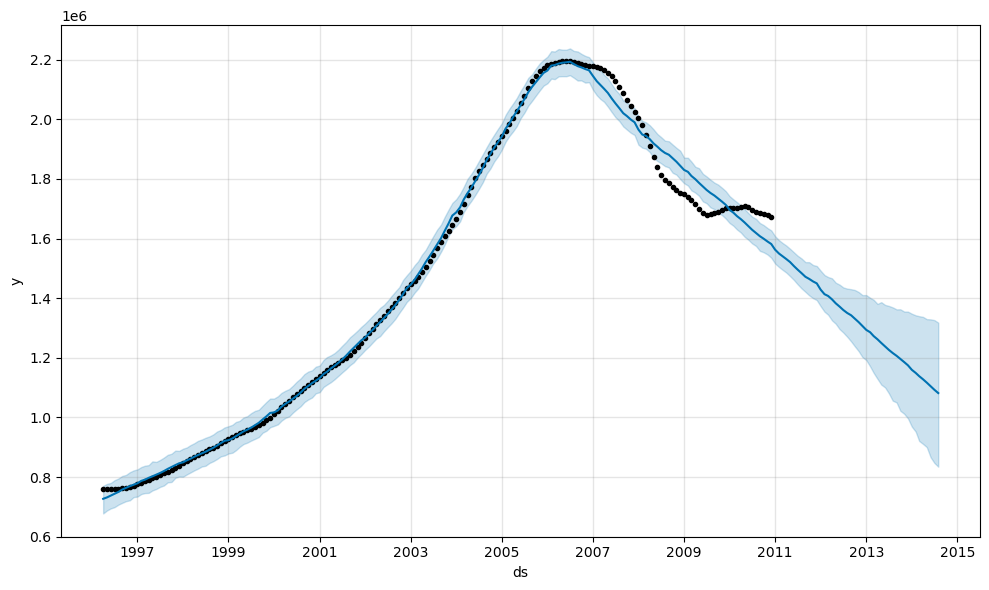

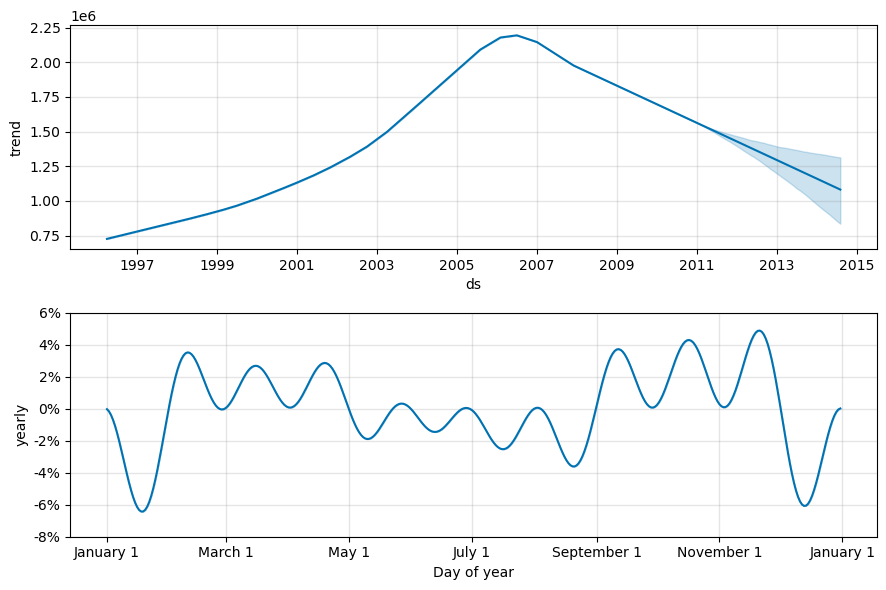

08:47:45 - cmdstanpy - INFO - Chain [1] start processing
08:47:45 - cmdstanpy - INFO - Chain [1] done processing


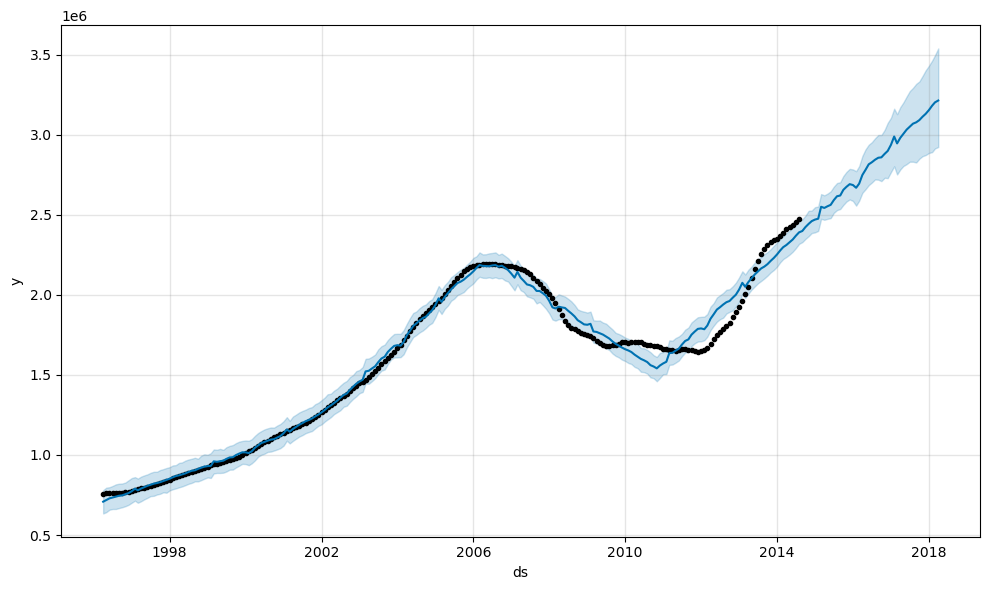

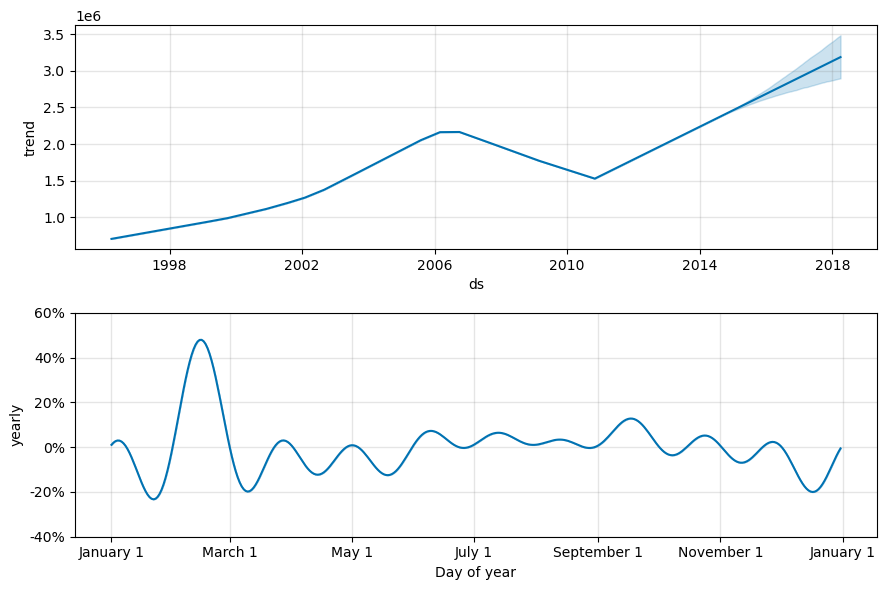

R2 = 0.20959916439874782, MSE = 20001670280.392387, RMSE = 141427.26144697983
R2 = 0.6229573492232394, MSE = 15377616013.25191, RMSE = 124006.51601126415
R2 = -21.1644107450975, MSE = 542170430156.7444, RMSE = 736322.2325563342
R2 = -5.494646784491055, MSE = 600108613162.4779, RMSE = 774666.7755638406
R2 = 0.750545813801742, MSE = 16527730701.208515, RMSE = 128560.22207980396


In [78]:
# Pipeline to predict the prices of the specified zip codes. 
class TimeSeriesPipeline2:
    def __init__(self, data_path, n_splits=5):
        self.data_path = data_path
        self.data = None
        self.model = None
        self.forecast = None
        self.n_splits = n_splits
    # Function to read in the data from the specified file path.
    def load_data(self):
        self.data = pd.read_csv(self.data_path)
    # Function to preprocess the data by converting the date column to datetime format,
    def preprocess_data(self, target_column='y', ds_column='ds'):
        self.data[ds_column] = pd.to_datetime(self.data[ds_column])
        self.data = self.data.rename(columns={ds_column: 'ds', target_column: 'y'})

        if self.data.duplicated('ds').any():
            self.data = self.data.drop_duplicates(subset='ds', keep='first')
    # Function to train the model on the training data.
    def train_model(self, train_data):
        self.model = Prophet(seasonality_mode='multiplicative')
        self.model.fit(train_data)
    # Function to make predictions on the test data.
    def make_predictions(self, test_data):
        future = self.model.make_future_dataframe(periods=len(test_data), freq='MS')
        self.forecast = self.model.predict(future)
    # Function to plot the forecast.
    def plot_forecast(self):
        fig = self.model.plot(self.forecast)
        fig2 = self.model.plot_components(self.forecast)
        plt.show()
    # Function to evaluate the model on the test data.
    def evaluate_model(self, test_data, y_true='y', y_pred='yhat'):
        y_true = test_data[y_true].values
        y_pred = self.forecast[-len(test_data):][y_pred].values
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)

        return r2, mse, rmse
    # Function to run the entire pipeline.
    def run_pipeline(self, target_column='y', ds_column='ds'):
        self.load_data()
        self.preprocess_data(target_column=target_column, ds_column=ds_column)

        tscv = TimeSeriesSplit(n_splits=self.n_splits)
        evaluation_scores = []
        for train_index, test_index in tscv.split(self.data):
            train_data, test_data = self.data.iloc[train_index], self.data.iloc[test_index]

            self.train_model(train_data)
            self.make_predictions(test_data)
            self.plot_forecast()
            r2, mse, rmse = self.evaluate_model(test_data, y_true='y', y_pred='yhat')
            evaluation_scores.append((r2, mse, rmse))
            
        return evaluation_scores  

# Pipeline to save the trained model.
class SaveModel(TimeSeriesPipeline2):
    def save_model(self, model_path='zipCode_value_predictor.pkl'):
        joblib.dump(self.model, model_path)


data_path = "Zipcode_predict.csv"
target_column = 'y'
pipeline = SaveModel(data_path)
evaluation_scores = pipeline.run_pipeline(target_column='value', ds_column='time')
pipeline.save_model()

# Print the scores for every fold. 
for i, scores in enumerate(evaluation_scores, 1):
    print(f"R2 = {scores[0]}, MSE = {scores[1]}, RMSE = {scores[2]}")


The prophet model handles seasonality very well, easy to use and in our case shows a very good R2 score of 75.05% so we used the prophet model for our prediction.
From the plots, what can be observed is that the model predicts an upward trend for house prices in the specific ZipCodes.
Seasonality has be handled well by the model and incase of a fututre crisis, the model has shown capabilities of anticipating it.

### <b><span style='color:#16C2D5'>|</span> Modelling Conclusion</b>

Two models were used specifically the baseline ARIMA model, the auto arima model to find the best pdq combinations, ARIMA models with the best combinations to minimize the AIC scores.

The ARIMA model with the lowest AIC scores of **776** was the one of order **0,2,0**. This model gave us the best possible forecasted values to answer our business objective. To find the forecasted value for each zipcode, the forecasted value was averaged.

The use of **TimeSeriesSplit** as a cross validation technique came in handy. This is because the data in the training and test sets is split into folds so as to get a variety of several forecasted value for each zipCode. These forecasted values are then averaged to get the real forecast value for every zipCode.



## 4. Conclusion


1.High value zipcodes demonstrated a high ROI indicating that they were good investment areas. They include:
* 10021, 10011, 10014, 90210 and 94027.

2. The market crisis had a severe effect on low value zipcodes 11217, 90049, 94022, and 94301.

3. The forecasting model had a R2 score of 74% for forecasting average house values per month. The second model had an accuracy score of 73.66% on the forecasting of house prices for the Regions(ZipCodes) with high house prices.

4. The metropolitan areas showing higher growth rates are Gleenwood Springs at 200% followed by Brunswick and Panama at 225% and 75% respectively. The ZipCodes(Regions) with high growth rates are 27980(2.5%), 30032(2%), 80216(1.75%) and 89030(1.5%).